In [2]:
import torch
import numpy as np
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

import pickle
import torch.nn as nn

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

from scipy.signal import savgol_filter

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

In [3]:
# Generate random input signal
num_simulations = 100000
num_samples = 100
t_max = 10
num_timesteps = 64
noise_std = 0.0025

# np.random.seed(4) # unsure if still need this here
seed = 42

# Generate random input signal
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

# Interpolate input signal to match time resolution
t = np.linspace(0, t_max, 500)
input_signal = np.interp(t, t_data, x_data[0, :, 0])

In [4]:
ts, dt = 30.0, 0.1
steps = int(ts / dt)

def amv(theta, tau_sequence=None, noise_std=0.0, seed=None):
    
    if seed is not None:
        np.random.seed(seed)

    Xu, Xuu, Yv, Yvv, Yr, Nv, Nr, Nrr = theta

    m   = 23.8
    Iz   = 1.76
    xg   = 0.046

    Xud  = -2
    Yvd  = -10
    Yrd  = 0
    Nvd  = 0
    Nrd  = -1

    m11 = m - Xud
    m22 = m - Yvd
    m23 = m * xg - Yrd
    m32 = m * xg - Nvd
    m33 = Iz - Nrd
    mt = m22 * m33 - m23 * m32

    a1 = dt * (m - Yvd) / (m - Xud)
    a2 = dt * (m * xg - Yrd) / (m - Xud)
    a3 = (-dt * (Iz - Nrd) * (m - Xud) / mt) + (dt * (m * xg - Yrd) * (m * xg - Yrd) / mt)
    a4 = dt * (m * xg - Yrd) * (Xud - Yvd) / mt
    a5 = (dt * (m * xg - Nvd) * (m - Xud) / mt) - (dt * (m - Yvd) * (m * xg - Yrd) / mt)
    a6 = -dt * (m - Yvd) * (Xud - Yvd) / mt

    b1  = dt * Xu / (m - Xud)
    b2  = dt * Xuu / (m - Xud)
    b3  = (dt * (Iz - Nrd) * Yv / mt) - (dt * (m * xg - Yrd) * Nv / mt)
    b4  = (dt * (Iz - Nrd) * Yr / mt) - (dt * (m * xg - Yrd) * Nr / mt)
    b5  = dt * (Iz - Nrd) * Yvv / mt
    b6  = -dt * (m * xg - Yrd) * Nrr / mt
    b7  = (dt * (m - Yvd) * Nv / mt) - (dt * (m * xg - Nvd) * Yv / mt)
    b8  = (dt * (m - Yvd) * Nr / mt) - (dt * (m * xg - Nvd) * Yr / mt)
    b9  = -dt * (m * xg - Nvd) * Yvv / mt
    b10 = dt * (m - Yvd) * Nrr / mt

    M = np.array([[m11, 0, 0], [0, m22, m23], [0, m32, m33]])
    B = dt * np.linalg.inv(M)
    
    zeta = np.array([
        a1, a2, b1, b2, a3, a4, b3, b4, b5, b6, a5, a6, b7, b8, b9, b10
    ])

    # Control input (default = fixed)
    if tau_sequence is None:
        tau_sequence = np.tile(np.array([[5, 10, 0]]), (steps, 1))
        # t = np.linspace(0, steps*dt, steps)
        # tau_sequence = np.zeros((steps, 3))
        # tau_sequence[:, 0] = 5 + 3 * np.sin(0.3 * t)       # surge
        # tau_sequence[:, 1] = 8 + 2 * np.sin(0.7 * t + 1.0) # sway
        # tau_sequence[:, 2] = 1.5 * np.sin(1.5 * t)         # yaw
        # tau_sequence *= noise_std

    # # Define time vector
    # te = np.linspace(0, steps * dt, steps)
    # # e.g., more energy in higher frequency or amplitude
    # tau_sequence[:, 2] = 1.5 * np.sin(1.5 * te) + 0.7 * np.random.randn(steps)

    # Initial state
    u, v, r = 0.0, 0.0, 0.0
    trajectory = []

    for i in range(steps):
        # Compute nonlinear basis vector f(ν_k)

        u_clamp = np.clip(u, -50, 50)
        v_clamp = np.clip(v, -50, 50)
        r_clamp = np.clip(r, -10, 10)

        f = np.array([
            [v_clamp * r_clamp, r_clamp**2, u_clamp, abs(u_clamp) * u_clamp, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, u_clamp * r_clamp, u_clamp * v_clamp, v_clamp, r_clamp, abs(v_clamp) * v_clamp, abs(r_clamp) * r_clamp, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, u_clamp * r_clamp, u_clamp * v_clamp, v_clamp, r_clamp, abs(v_clamp) * v_clamp, abs(r_clamp) * r_clamp]
        ])

        # Compute state update
        dnu = f @ zeta + (B @ tau_sequence[i].reshape(3, 1)).flatten()

        # Add noise if requested
        if noise_std > 0:
            dnu += np.random.normal(scale=noise_std, size=3)

        # Update state
        u, v, r = u + dnu[0], v + dnu[1], r + dnu[2]

        # Save state
        trajectory.append([u, v, r])

    return torch.tensor(trajectory, dtype=torch.float32)

In [5]:
def random_tau_sequence(seed=None, noise=1):

    if seed is not None:
        np.random.seed(seed)

    t = np.linspace(0, ts, steps)
    tau = np.stack([
        5 * np.sin(0.2 * t) + 0.5 * np.random.randn(steps),
        3 * np.cos(0.1 * t) + 0.5 * np.random.randn(steps),
        0.2 * np.sin(0.4 * t)
    ], axis=1)
    return tau * noise

In [6]:
def smooth_trajectory(trajectory):
    return torch.tensor(np.stack([
        savgol_filter(trajectory[:, i].numpy(), window_length=15, polyorder=3)
        for i in range(trajectory.shape[1])
    ], axis=1))

In [7]:
# def extract_summary_stats(trajectory: torch.Tensor, dt: float = 0.1):
#     data = trajectory.numpy()  # shape (T, 3)
#     summaries = []

#     for i in range(3):  # for u, v, r
#         x = data[:, i]

#         # Time-domain features
#         mean = np.mean(x)
#         std = np.std(x)
#         final = x[-1]
#         max_val = np.max(x)
#         min_val = np.min(x)
#         peak_val = np.max(np.abs(x))
#         peak_idx = np.argmax(np.abs(x))
#         peak_time = peak_idx * dt
#         rms = np.sqrt(np.mean(x**2))

#         # Step-response features
#         overshoot = (max_val - final) / (final + 1e-8) if final != 0 else 0
#         settling_time = next((i * dt for i in range(len(x)-1, -1, -1)
#                               if abs(x[i] - final) > 0.02 * abs(final)), 0)

#         # Frequency-domain (FFT)
#         fft_vals = np.abs(rfft(x - np.mean(x)))
#         freqs = rfftfreq(len(x), d=dt)
#         power = fft_vals**2
#         dominant_freq = freqs[np.argmax(power)]
#         spectral_power = np.max(power)
#         norm_power = power / (np.sum(power) + 1e-8)
#         spec_entropy = entropy(norm_power)

#         summaries.extend([
#             mean, std, final, max_val, min_val,
#             peak_val, peak_time, rms,
#             dominant_freq, spectral_power, spec_entropy,
#             overshoot, settling_time
#         ])

#         # Additional targeted stats for yaw channel r(t)
#         r = data[:, 2]  # yaw rate

#         # Linear damping indicators (Nr)
#         rms_r = np.sqrt(np.mean(r**2))
#         mean_abs_r = np.mean(np.abs(r))
#         autocorr_r = np.corrcoef(r[:-1], r[1:])[0, 1] if len(r) > 1 else 0.0

#         # Nonlinear damping indicators (Nrr)
#         skew_r = skew(r)
#         kurt_r = kurtosis(r)
#         nonlinear_term = np.mean(r * np.abs(r))
#         high_r_ratio = np.mean(np.abs(r) > 0.5)

#         summaries.extend([
#             rms_r, mean_abs_r, autocorr_r,
#             skew_r, kurt_r, nonlinear_term, high_r_ratio
#         ])

#         # Common nonlinear energy features
#         nonlinear_drag = np.mean(x * np.abs(x))           # captures |x|·x
#         high_amp_ratio = np.mean(np.abs(x) > 0.5 * np.max(np.abs(x)))  # time spent at high velocity
#         derivative = np.diff(x) / dt
#         jerk = np.diff(derivative) / dt

#         # Derivative-based features (damping shape)
#         rms_dx = np.sqrt(np.mean(derivative**2)) if len(derivative) > 1 else 0
#         max_jerk = np.max(np.abs(jerk)) if len(jerk) > 1 else 0

#         # Asymmetry (nonlinear damping often introduces skew)
#         x_skew = skew(x)
#         x_kurt = kurtosis(x)

#         summaries.extend([
#             nonlinear_drag,
#             high_amp_ratio,
#             rms_dx,
#             max_jerk,
#             x_skew,
#             x_kurt
#         ])

#         # summaries.extend([
#         #         mean,
#         #         rms,
#         #         peak_val,
#         #         dominant_freq,
#         #         spec_entropy,
#         #         overshoot,

#         #         nonlinear_drag,
#         #         high_amp_ratio,
#         #         rms_dx,
#         #         max_jerk,
#         #         x_skew,
#         #         x_kurt,
#         # ])

#     return torch.tensor(summaries, dtype=torch.float32)

In [8]:
def extract_summary_stats(trajectory: torch.Tensor, dt: float = 0.1):
    data = trajectory.numpy()
    u, v, r = data[:, 0], data[:, 1], data[:, 2]
    
    stats = []

    for x in [u, v, r]:
        stats += [np.mean(x), np.std(x), np.max(x), np.min(x), x[-1], np.sqrt(np.mean(x**2))]

    # Nonlinear features
    stats += [np.mean(np.abs(u)*u), np.max(np.abs(u)*u)]
    stats += [np.mean(np.abs(v)*v), np.max(np.abs(v)*v)]
    stats += [np.mean(np.abs(r)*r), np.max(np.abs(r)*r)]

    # Cross products
    stats += [np.mean(v*r), np.mean(u*r), np.mean(u*v)]

    # Step-response style
    def overshoot_and_settling(x):
        final = x[-1]
        overshoot = (np.max(x) - final) / (final + 1e-6)
        settling_idx = next((i for i in reversed(range(len(x))) if abs(x[i] - final) > 0.02 * abs(final)), 0)
        settling_time = settling_idx * dt
        return overshoot, settling_time

    for x in [v, r]:
        stats += list(overshoot_and_settling(x))

    return torch.tensor(stats, dtype=torch.float32)

In [9]:
# def extract_summary_stats(trajectory: torch.Tensor, dt: float = 0.1):
#     data = trajectory.numpy()  # shape (T, 3)
#     summaries = []

#     for i in range(3):  # for u, v, r
#         x = data[:, i]

#         # Time-domain features
#         mean = np.mean(x)
#         std = np.std(x)
#         final = x[-1]
#         max_val = np.max(x)
#         min_val = np.min(x)
#         peak_val = np.max(np.abs(x))
#         peak_idx = np.argmax(np.abs(x))
#         peak_time = peak_idx * dt
#         rms = np.sqrt(np.mean(x**2))

#         # Step-response features
#         overshoot = (max_val - final) / (final + 1e-8) if final != 0 else 0
#         settling_time = next((i * dt for i in range(len(x)-1, -1, -1)
#                               if abs(x[i] - final) > 0.02 * abs(final)), 0)

#         # Frequency-domain (FFT)
#         fft_vals = np.abs(rfft(x - np.mean(x)))
#         freqs = rfftfreq(len(x), d=dt)
#         power = fft_vals**2
#         dominant_freq = freqs[np.argmax(power)]
#         spectral_power = np.max(power)
#         norm_power = power / (np.sum(power) + 1e-8)
#         spec_entropy = entropy(norm_power)

#         # summaries.extend([
#         #     mean, std, final, max_val, min_val,
#         #     peak_val, peak_time, rms,
#         #     dominant_freq, spectral_power, spec_entropy,
#         #     overshoot, settling_time
#         # ])

#         # # Additional targeted stats for yaw channel r(t)
#         # r = data[:, 2]  # yaw rate

#         # # Linear damping indicators (Nr)
#         # rms_r = np.sqrt(np.mean(r**2))
#         # mean_abs_r = np.mean(np.abs(r))
#         # autocorr_r = np.corrcoef(r[:-1], r[1:])[0, 1] if len(r) > 1 else 0.0

#         # # Nonlinear damping indicators (Nrr)
#         # skew_r = skew(r)
#         # kurt_r = kurtosis(r)
#         # nonlinear_term = np.mean(r * np.abs(r))
#         # high_r_ratio = np.mean(np.abs(r) > 0.5)

#         # summaries.extend([
#         #     rms_r, mean_abs_r, autocorr_r,
#         #     skew_r, kurt_r, nonlinear_term, high_r_ratio
#         # ])

#         # Common nonlinear energy features
#         nonlinear_drag = np.mean(x * np.abs(x))           # captures |x|·x
#         high_amp_ratio = np.mean(np.abs(x) > 0.5 * np.max(np.abs(x)))  # time spent at high velocity
#         derivative = np.diff(x) / dt
#         jerk = np.diff(derivative) / dt

#         # Derivative-based features (damping shape)
#         rms_dx = np.sqrt(np.mean(derivative**2)) if len(derivative) > 1 else 0
#         max_jerk = np.max(np.abs(jerk)) if len(jerk) > 1 else 0

#         # Asymmetry (nonlinear damping often introduces skew)
#         x_skew = skew(x)
#         x_kurt = kurtosis(x)

#         # summaries.extend([
#         #     nonlinear_drag,
#         #     high_amp_ratio,
#         #     rms_dx,
#         #     max_jerk,
#         #     x_skew,
#         #     x_kurt
#         # ])

#         summaries.extend([
#                 mean,
#                 rms,
#                 peak_val,
#                 dominant_freq,
#                 spec_entropy,
#                 overshoot,

#                 nonlinear_drag,
#                 high_amp_ratio,
#                 rms_dx,
#                 max_jerk,
#                 x_skew,
#                 x_kurt,
#         ])

#     # Just for yaw

#     # Additional targeted stats for yaw channel r(t)
#     r = data[:, 2]  # yaw rate

#     # Linear damping indicators (Nr)
#     rms_r = np.sqrt(np.mean(r**2))
#     mean_abs_r = np.mean(np.abs(r))
#     autocorr_r = np.corrcoef(r[:-1], r[1:])[0, 1] if len(r) > 1 else 0.0

#     # Nonlinear damping indicators (Nrr)
#     skew_r = skew(r)
#     kurt_r = kurtosis(r)
#     nonlinear_term = np.mean(r * np.abs(r))
#     high_r_ratio = np.mean(np.abs(r) > 0.5)

#     # Only needed once
#     summaries.extend([
#         rms_r, mean_abs_r, autocorr_r,
#         skew_r, kurt_r, nonlinear_term, high_r_ratio
#     ])

#     return torch.tensor(summaries, dtype=torch.float32)

In [10]:
def simulator(theta: torch.Tensor, seed=None) -> torch.Tensor:
    trajectory = amv(theta.numpy(), random_tau_sequence(seed), noise_std=noise_std, seed=seed)
    trajectory_smooth = torch.tensor(np.stack([
        savgol_filter(trajectory[:, i], window_length=15, polyorder=3)
        for i in range(trajectory.shape[1])
    ], axis=1), dtype=torch.float32)

    summary = extract_summary_stats(trajectory_smooth)
    return (summary - summary_mean) / (summary_std + 1e-8)

In [11]:
# True parameters
m_true   = 23.8
Iz_true   = 1.76
xg_true   = 0.046

Xud_true  = -2
Yvd_true  = -10
Yrd_true  = 0
Nvd_true  = 0
Nrd_true  = -1

Xu_true   = -0.7225
Xuu_true  = -1.3274
Yv_true   = -0.8612
Yvv_true  = -36.2823
Yr_true   = 0.1079
Nv_true   = 0.1052
Nr_true  = -0.5
Nrr_true = -1

true_params = torch.tensor([Xu_true, Xuu_true, Yv_true, Yvv_true, Yr_true, Nv_true, Nr_true, Nrr_true])

In [21]:
x_obs = amv(true_params.numpy(), noise_std=0.0005)

true_trajectory = torch.tensor(np.stack([
    savgol_filter(x_obs[:, i], window_length=15, polyorder=3)
    for i in range(x_obs.shape[1])
], axis=1))

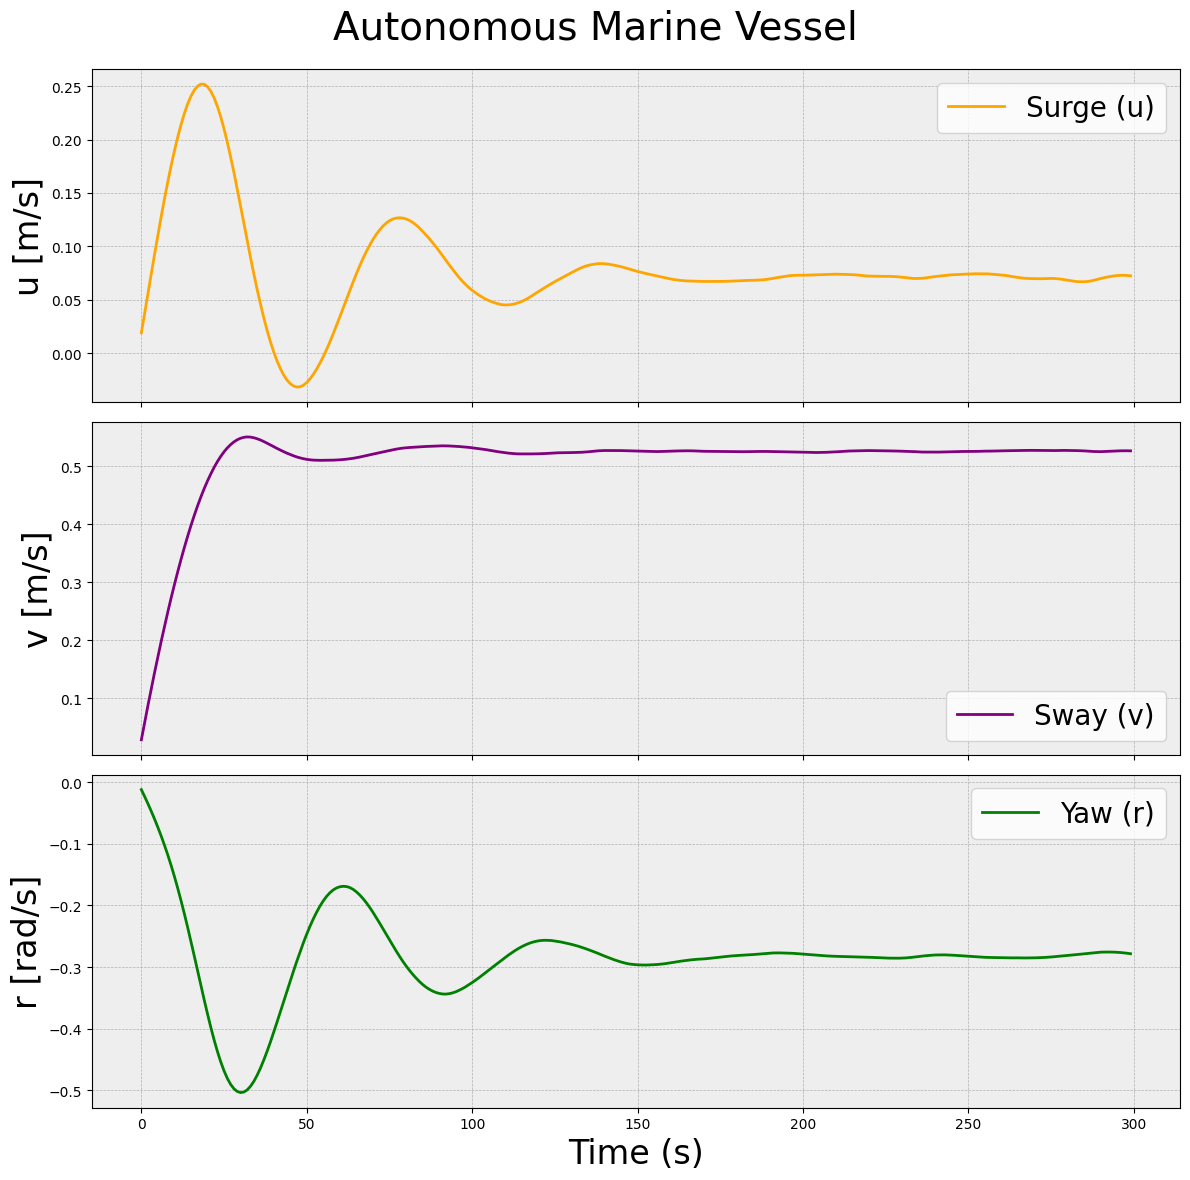

In [25]:
t = torch.arange(true_trajectory.shape[0])

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define colors
bg_color = '#EEEEEE'
line_width = 2  # Thinner line
font_size = 24

# Set the figure title
fig.suptitle('Autonomous Marine Vessel', fontsize=font_size+4)

# Subplot 1: u [m/s]
axes[0].plot(t, true_trajectory[:, 0], '-', color='orange', linewidth=line_width, label='Surge (u)')
axes[0].set_ylabel('u [m/s]', fontsize=font_size)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_facecolor(bg_color)
axes[0].legend(fontsize=font_size-4)

# Subplot 2: v [m/s]
axes[1].plot(t, true_trajectory[:, 1], '-', color='purple', linewidth=line_width, label='Sway (v)')
axes[1].set_ylabel('v [m/s]', fontsize=font_size)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_facecolor(bg_color)
axes[1].legend(fontsize=font_size-4)

# Subplot 3: r [rad/s]
axes[2].plot(t, true_trajectory[:, 2], '-', color='green', linewidth=line_width, label='Yaw (r)')
axes[2].set_ylabel('r [rad/s]', fontsize=font_size)
axes[2].set_xlabel('Time (s)', fontsize=font_size)
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[2].set_facecolor(bg_color)
axes[2].legend(fontsize=font_size-4)

# Apply general figure settings
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for suptitle
plt.show()

In [14]:
low = torch.tensor([
    -2.0,  # Xu
    -2.0,  # Xuu
    -2.0,  # Yv
    -50.0, # Yvv
    -1.0,  # Yr
    -1.0,  # Nv
    -1.5,  # Nr
    -2.0   # Nrr
])

high = torch.tensor([
    0.0,
    0.0,
    0.0,
    -20.0,
    1.0,
    1.0,
    0.0,
    0.0
])


# low = torch.tensor([
#     -5.0,  # Xu
#     -5.0,  # Xuu
#     -5.0,  # Yv
#     -40.0, # Yvv
#     -5.0,  # Yr
#     -5.0,  # Nv
#     -5.0,  # Nr
#     -5.0   # Nrr
# ])

# high = torch.tensor([
#     0.0,
#     0.0,
#     0.0,
#     -35.0,
#     5.0,
#     5.0,
#     0.0,
#     0.0
# ])


# low = torch.tensor([
#     -2.0,  # Xu
#     -2.0,  # Xuu
#     -2.0,  # Yv
#     -36.2824, # Yvv
#     -1.0,  # Yr
#     -1.0,  # Nv
#     -0.51,  # Nr
#     -2.0   # Nrr
# ])

# high = torch.tensor([
#     0.0,
#     0.0,
#     0.0,
#     -36.2822,
#     1.0,
#     1.0,
#     -0.49,
#     0.0
# ])

In [15]:
prior = BoxUniform(
    low=low,
    high=high
)
prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [16]:
raw_simulator = lambda theta: extract_summary_stats(amv(theta.numpy(), noise_std=noise_std, seed=None))

theta_batch = prior.sample((100,))
summaries = torch.stack([raw_simulator(theta) for theta in theta_batch])

summary_mean = summaries.mean(dim=0)
summary_std = summaries.std(dim=0)

In [17]:
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [18]:
inference = NPE(prior=prior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
density_estimator = inference.append_simulations(theta, x).train()

100%|██████████| 100000/100000 [12:12<00:00, 136.56it/s]


 Neural network successfully converged after 270 epochs.

In [19]:
posterior = inference.build_posterior(density_estimator)

In [20]:
x_summary_obs = simulator(true_params, seed=seed)
test_params = prior.sample((1,))[0]
x_summary_obs_rand = simulator(test_params, seed=seed)

In [21]:
# Infer parameters
samples = posterior.sample((10000,), x=x_summary_obs_rand)
inferred = samples.mean(dim=0)
std_dev = samples.std(dim=0)
ci_low = samples.quantile(0.025, dim=0)
ci_high = samples.quantile(0.975, dim=0)

# Calculate error metrics
abs_error = torch.abs(inferred - true_params)
rel_error = 100 * abs_error / torch.abs(true_params)
squared_error = (inferred - true_params) ** 2

# Print parameter values
print(f"Xu \ttrue: {true_params[0]:.3f}, \tinferred: {inferred[0]:.3f}")
print(f"Xuu \ttrue: {true_params[1]:.3f}, \tinferred: {inferred[1]:.3f}")
print(f"Yv \ttrue: {true_params[2]:.3f}, \tinferred: {inferred[2]:.3f}")
print(f"Yvv \ttrue: {true_params[3]:.3f}, \tinferred: {inferred[3]:.3f}")
print(f"Yr \ttrue: {true_params[4]:.3f}, \tinferred: {inferred[4]:.3f}")
print(f"Nv \ttrue: {true_params[5]:.3f}, \tinferred: {inferred[5]:.3f}")
print(f"Nr \ttrue: {true_params[6]:.3f}, \tinferred: {inferred[6]:.3f}")
print(f"Nrr \ttrue: {true_params[7]:.3f}, \tinferred: {inferred[7]:.3f}")

# Print error metrics
print("\nError Analysis:")
print(f"Mean Squared Error (MSE): {squared_error.mean().item():.4f}")
print(f"Mean Absolute Error (MAE): {abs_error.mean().item():.4f}")
print(f"Mean Absolute Percent Error (MAPE): {rel_error.mean().item():.2f}%")

# Detailed parameter-wise analysis
print("\nDetailed Parameter Analysis:")
print(f"{'Parameter':<8} {'True':<8} {'Inferred':<10} {'Std':<8} {'2.5% CI':<10} {'97.5% CI':<10} {'Abs. Error':<12} {'Rel. Error (%)':<15} {'MSE':<8}")
print("-" * 90)

for i, param in enumerate(['Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr']):
    print(f"{param:<8} {true_params[i]:.4f}  {inferred[i]:.4f}    {std_dev[i]:.4f}   {ci_low[i]:.4f}     {ci_high[i]:.4f}      {abs_error[i]:.4f}      {rel_error[i]:.2f}%          {squared_error[i]:.4f}")

Drawing 10000 posterior samples: 10549it [00:00, 52764.99it/s]                          

Xu 	true: -0.723, 	inferred: -1.255
Xuu 	true: -1.327, 	inferred: -1.016
Yv 	true: -0.861, 	inferred: -1.126
Yvv 	true: -36.282, 	inferred: -31.162
Yr 	true: 0.108, 	inferred: -0.457
Nv 	true: 0.105, 	inferred: -0.554
Nr 	true: -0.500, 	inferred: -0.757
Nrr 	true: -1.000, 	inferred: -0.892

Error Analysis:
Mean Squared Error (MSE): 3.4374
Mean Absolute Error (MAE): 0.9771
Mean Absolute Percent Error (MAPE): 169.23%

Detailed Parameter Analysis:
Parameter True     Inferred   Std      2.5% CI    97.5% CI   Abs. Error   Rel. Error (%)  MSE     
------------------------------------------------------------------------------------------
Xu       -0.7225  -1.2546    0.2998   -1.8234     -0.6768      0.5321      73.64%          0.2831
Xuu      -1.3274  -1.0163    0.4252   -1.8343     -0.2066      0.3111      23.44%          0.0968
Yv       -0.8612  -1.1264    0.4482   -1.9065     -0.2252      0.2652      30.80%          0.0703
Yvv      -36.2823  -31.1619    1.5849   -34.3302     -28.2701      

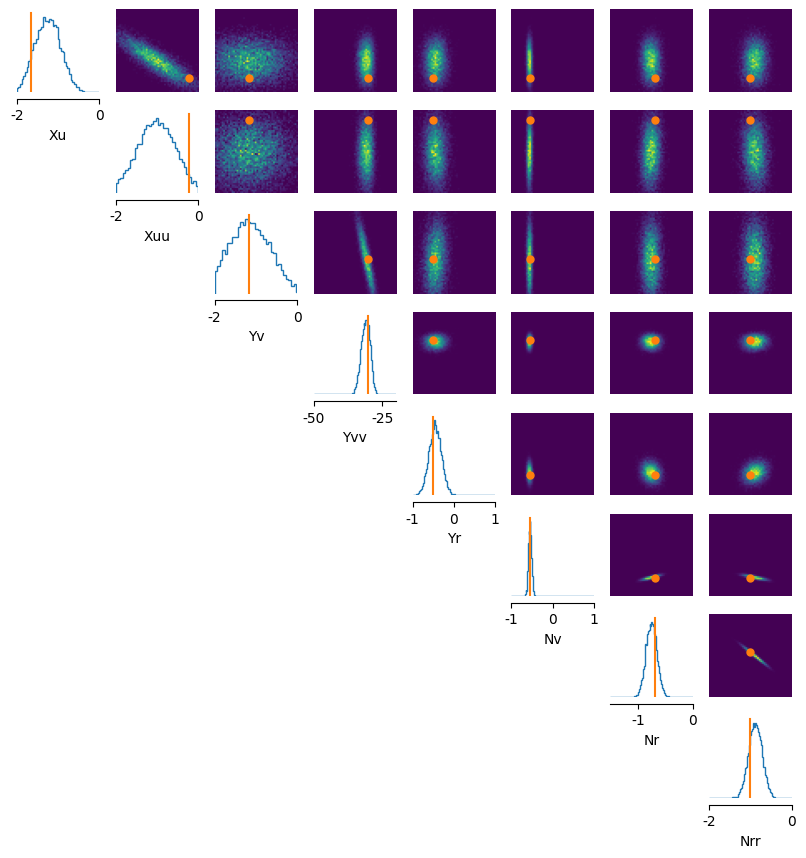

In [23]:
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]
labels=['Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr']

fig, ax = analysis.pairplot(
    samples,
    points=test_params,
    labels=labels,
    limits=limits,
)

In [96]:
def plot_posterior_prediction_band_amv(
    posterior,
    x_o,
    simulator_raw,
    num_samples=100,
    show_samples=False,
    color='C0',
    label='Posterior Predictive',
    seed=None
):
    import matplotlib.pyplot as plt
    import numpy as np

    u_traj, v_traj, r_traj = [], [], []
    t_ref = None

    true = simulator_raw(true_params, noise_std=noise_std, seed=seed)
    true = smooth_trajectory(true)
    theta_samples = posterior.sample((num_samples,), x=x_o, show_progress_bars=False)
    for theta in theta_samples.numpy():
        trajectory = simulator_raw(theta, noise_std=noise_std, seed=seed)
        trajectory = smooth_trajectory(trajectory)
        if t_ref is None:
            t_ref = np.linspace(0, trajectory.shape[0]*0.1, trajectory.shape[0])
        u_traj.append(trajectory[:, 0].numpy())
        v_traj.append(trajectory[:, 1].numpy())
        r_traj.append(trajectory[:, 2].numpy())

    u_traj = np.stack(u_traj)
    v_traj = np.stack(v_traj)
    r_traj = np.stack(r_traj)

    # inferred = theta_samples.mean(dim=0)
    # # Simulate the trajectory for the mean of the inferred parameters
    # inferred_trajectory = simulator_raw(inferred, noise_std=noise_std, seed=seed)
    # inferred_trajectory = smooth_trajectory(inferred_trajectory)

    # # Extract the trajectories for plotting
    # inferred_u = inferred_trajectory[:, 0].numpy()
    # inferred_v = inferred_trajectory[:, 1].numpy()
    # inferred_r = inferred_trajectory[:, 2].numpy()

    # # Create time vector for plotting the inferred trajectory
    # t_inf = np.linspace(0, inferred_trajectory.shape[0]*0.1, inferred_trajectory.shape[0])

    def plot_band(data, t, base_color, variable_name):
        quantiles = [50, 70, 90]
        alphas = [0.25, 0.18, 0.12]
        for q, alpha in zip(quantiles, alphas):
            lower = np.percentile(data, 50 - q/2, axis=0)
            upper = np.percentile(data, 50 + q/2, axis=0)
            plt.fill_between(t, lower, upper, color=base_color, alpha=alpha,
                             label=f'{label} {variable_name} ({q}% CI)' if q == 90 else None)
        median = np.median(data, axis=0)
        plt.plot(t, median, color=base_color, lw=2, label=f'{label} {variable_name} (Median)')
        if show_samples:
            for traj in data:
                plt.plot(t, traj, color=base_color, alpha=0.05, lw=0.5)
    
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    plot_band(u_traj, t_ref, 'C0', '$u$ [m/s]')
    plt.plot(t_ref, true[:, 0].numpy(), '--k', label='True $u$', linewidth=2)
    # plt.plot(t_inf, inferred_u, color='k', lw=2, linestyle='--', label='Posterior')
    plt.ylabel("u [m/s]")
    plt.grid()

    plt.subplot(3, 1, 2)
    plot_band(v_traj, t_ref, 'C1', '$v$ [m/s]')
    plt.plot(t_ref, true[:, 1].numpy(), '--r', label='True $v$', linewidth=2)
    # plt.plot(t_inf, inferred_v, color='k', lw=2, linestyle='--', label='Posterior')
    plt.ylabel("v [m/s]")
    plt.grid()

    plt.subplot(3, 1, 3)
    plot_band(r_traj, t_ref, 'C2', '$r$ [rad/s]')
    plt.plot(t_ref, true[:, 2].numpy(), '--g', label='True $r$', linewidth=2)
    # plt.plot(t_inf, inferred_r, color='k', lw=2, linestyle='--', label='Posterior')
    plt.ylabel("r [rad/s]")
    plt.xlabel("Time [s]")
    plt.grid()

    plt.tight_layout()
    plt.legend()
    plt.show()

# def plot_posterior_prediction_band_hybrid(
#     posterior,
#     x_o,
#     simulator_hybrid,
#     true_hybrid,
#     num_samples=200,
#     show_samples=False,
#     steps=300,
#     dt=0.1,
#     seed=None
# ):
#     import matplotlib.pyplot as plt
#     import numpy as np

#     u_traj, v_traj, r_traj = [], [], []
#     t_ref = np.linspace(0, dt * (steps - 1), steps)

#     theta_samples = posterior.sample((num_samples,), x=x_o).numpy()

#     for theta in theta_samples:
#         hybrid_vector = simulator_hybrid(torch.tensor(theta), seed=seed)
#         traj = hybrid_vector[:3 * steps].reshape(3, steps).T  # shape [steps, 3]
#         traj = smooth_trajectory(traj)
#         u_traj.append(traj[:, 0].detach().numpy())
#         v_traj.append(traj[:, 1].detach().numpy())
#         r_traj.append(traj[:, 2].detach().numpy())

#     u_traj = np.stack(u_traj)
#     v_traj = np.stack(v_traj)
#     r_traj = np.stack(r_traj)

#     # Extract true trajectory
#     true_traj = true_hybrid[:3 * steps].reshape(3, steps).T
#     true_traj = smooth_trajectory(true_traj)

#     def plot_band(data, t, base_color, variable_name, true_vals):
#         quantiles = [50, 70, 90]
#         alphas = [0.25, 0.18, 0.12]
#         for q, alpha in zip(quantiles, alphas):
#             lower = np.percentile(data, 50 - q/2, axis=0)
#             upper = np.percentile(data, 50 + q/2, axis=0)
#             plt.fill_between(t, lower, upper, color=base_color, alpha=alpha,
#                              label=f'Posterior Predictive {variable_name} ({q}% CI)' if q == 90 else None)
#         median = np.median(data, axis=0)
#         plt.plot(t, median, color=base_color, lw=2, label=f'Posterior Predictive {variable_name} (Median)')
#         plt.plot(t, true_vals, '--k', lw=2, label=f'True {variable_name}')
#         if show_samples:
#             for traj in data:
#                 plt.plot(t, traj, color=base_color, alpha=0.05, lw=0.5)

#     plt.figure(figsize=(12, 10))

#     plt.subplot(3, 1, 1)
#     plot_band(u_traj, t_ref, 'C0', '$u$ [m/s]', true_traj[:, 0].detach().numpy())
#     plt.ylabel("u [m/s]")
#     plt.grid()

#     plt.subplot(3, 1, 2)
#     plot_band(v_traj, t_ref, 'C1', '$v$ [m/s]', true_traj[:, 1].detach().numpy())
#     plt.ylabel("v [m/s]")
#     plt.grid()

#     plt.subplot(3, 1, 3)
#     plot_band(r_traj, t_ref, 'C2', '$r$ [rad/s]', true_traj[:, 2].detach().numpy())
#     plt.ylabel("r [rad/s]")
#     plt.xlabel("Time [s]")
#     plt.grid()

#     plt.tight_layout()
#     plt.legend()
#     plt.show()

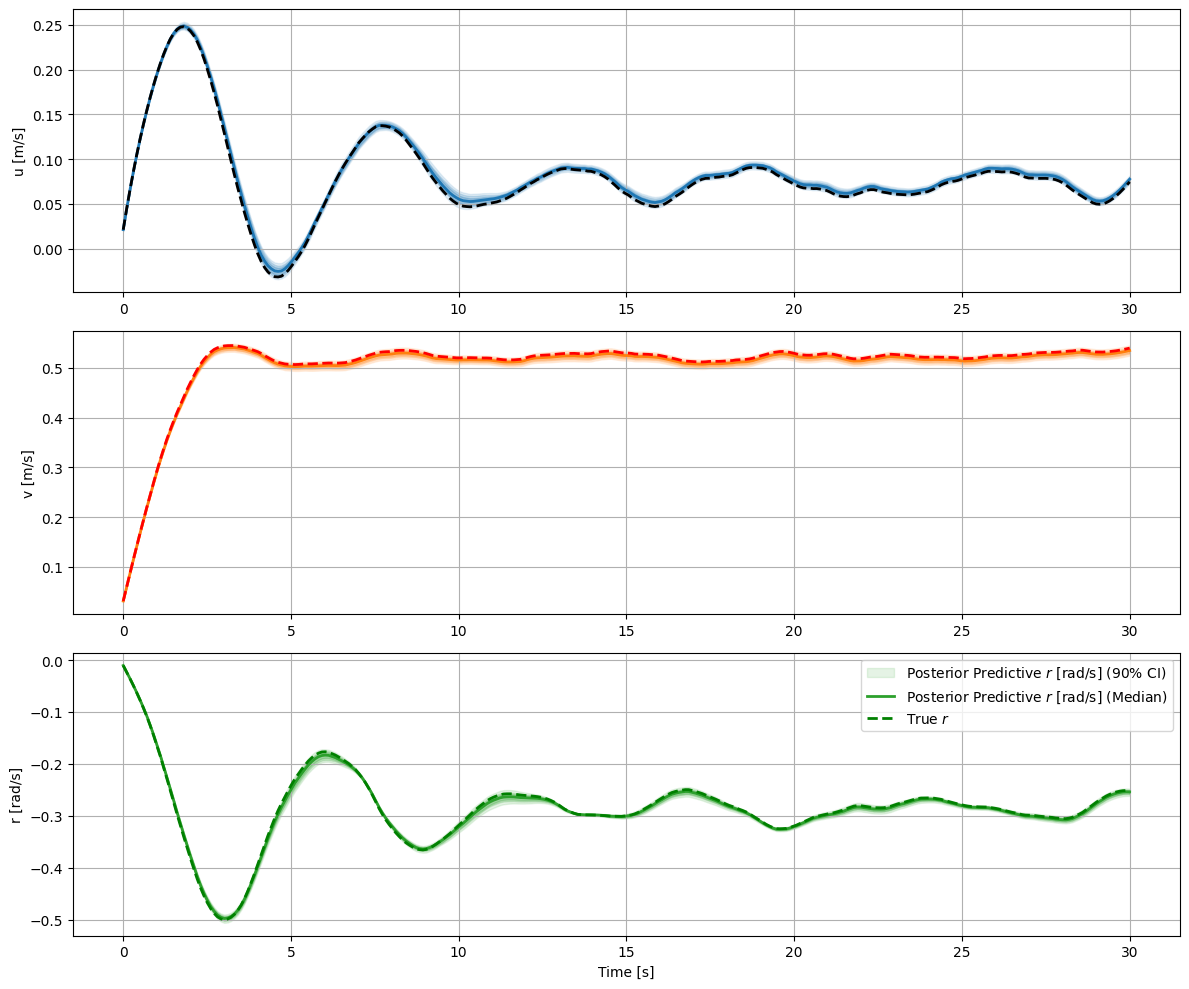

In [97]:
plot_posterior_prediction_band_amv(
    posterior,
    x_summary_obs,
    simulator_raw=amv,
    num_samples=200,
    show_samples=False,
    seed=seed
)

In [92]:


# # Plot or log summary[i] vs delta

# # Create a figure to display the sensitivity analysis
# plt.figure(figsize=(15, 10))

# parameter_names = ['Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr']
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

# for i in range(8):
#     theta_base = true_params.clone()
#     deltas = [-0.1, 0, 0.1]  # Adding 0 to see baseline
#     summaries = []
    
#     for delta in deltas:
#         theta_shifted = theta_base.clone()
#         if delta != 0:  # Skip modification for baseline
#             theta_shifted[i] += delta
        
#         # Get summary statistics
#         summary = extract_summary_stats(amv(theta_shifted.numpy()))
#         summaries.append(summary.numpy())
    
#     # Convert to numpy array for easier indexing
#     summaries = np.array(summaries)
    
#     # Plot the changes in summary statistics for this parameter
#     plt.subplot(2, 4, i+1)
    
#     # Calculate percentage change from baseline for visualization
#     baseline = summaries[1]  # middle element is baseline (delta=0)
#     changes = [(s - baseline) / (np.abs(baseline) + 1e-8) * 100 for s in summaries]


#     # # Plot the changes for each summary statistic
#     # for j in range(49):  # Limit to first 10 stats for clarity
#     #     plt.plot(deltas, [change[j] for change in changes], 'o-', label=f'Stat {j}')

#     plt.plot(deltas, [change[50] for change in changes], 'o-')
    
#     plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
#     plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
#     plt.title(f'Parameter: {parameter_names[i]}')
#     plt.xlabel('Parameter Perturbation')
#     plt.ylabel('% Change in Summary Stats')
#     plt.grid(alpha=0.3)

# plt.tight_layout()
# plt.savefig('parameter_sensitivity.png', dpi=300)
# plt.show()

In [17]:
class LSTMEmbedding(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=16, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,  # 3 = u, v, r
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_net = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, T, C]
        _, (hn, _) = self.lstm(x)
        return self.output_net(hn[-1])

In [18]:
class HybridEmbedding(nn.Module):
    def __init__(self, seq_embed_net, stats_dim=39, seq_channels=3, seq_len=300, fused_dim=16):
        super().__init__()
        self.seq_embed_net = seq_embed_net
        self.seq_shape = (seq_channels, seq_len)
        self.stats_dim = stats_dim

        self.stats_fc = nn.Sequential(
            nn.Linear(stats_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.fusion = nn.Sequential(
            nn.Linear(16 + fused_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):  # x: [B, 3*300 + 39]
        seq_flat = x[:, :-self.stats_dim]
        stats = x[:, -self.stats_dim:]

        seq = seq_flat.view(x.shape[0], *self.seq_shape)
        seq_embed = self.seq_embed_net(seq)
        stats_embed = self.stats_fc(stats)

        return self.fusion(torch.cat([seq_embed, stats_embed], dim=1))

In [19]:
def simulator_hybrid(theta: torch.Tensor, seed=None) -> torch.Tensor:

    trajectory = amv(theta.numpy(), noise_std=noise_std, seed=seed)
    trajectory_smooth = smooth_trajectory(trajectory)

    sequence = trajectory_smooth.T  # [3, steps]
    
    stats = extract_summary_stats(trajectory_smooth)
    stats_norm = (stats - summary_mean) / (summary_std + 1e-8)

    hybrid_vector = torch.cat([sequence.flatten(), stats_norm])
    return hybrid_vector

In [20]:
embedding_net = HybridEmbedding(
    seq_embed_net=LSTMEmbedding(input_size=3),
    stats_dim=31,
    seq_channels=3,
    seq_len=steps
)

In [21]:
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)

In [26]:
# theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
inference = NPE(prior=prior, density_estimator=density_estimator)

In [ ]:
import time


simulator_wrapper = process_simulator(simulator_hybrid, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

# Start timing for simulation
sim_start_time = time.time()
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=400000)
sim_end_time = time.time()
sim_elapsed_time = sim_end_time - sim_start_time
print(f"Simulation time for 400,000 samples: {sim_elapsed_time:.2f} seconds ({sim_elapsed_time/60:.2f} minutes)")

100%|██████████| 400000/400000 [52:11<00:00, 127.74it/s] 


Simulation time for 400,000 samples: 3133.43 seconds (52.22 minutes)


In [26]:
import pandas as pd
import numpy as np

def save_simulation_to_csv(theta, x, filepath="simulation_data.csv"):
    
    # Convert theta to numpy array if it's a tensor
    if isinstance(theta, torch.Tensor):
        theta_np = theta.cpu().numpy()
    else:
        theta_np = np.array(theta)
    
    # Convert x to numpy array if it's a tensor
    if isinstance(x, torch.Tensor):
        x_np = x.cpu().numpy()
    else:
        x_np = np.array(x)
    
    # Create column names
    theta_cols = [f'theta_{i}' for i in range(theta_np.shape[1])]
    x_cols = [f'x_{i}' for i in range(x_np.shape[1])]
    
    # Create DataFrames
    theta_df = pd.DataFrame(theta_np, columns=theta_cols)
    x_df = pd.DataFrame(x_np, columns=x_cols)
    
    # Concatenate DataFrames
    full_df = pd.concat([theta_df, x_df], axis=1)
    
    # Save to CSV
    full_df.to_csv(filepath, index=False)
    print(f"Data saved to {filepath}")
    
    return full_df

In [23]:
import pandas as pd
import numpy as np

# Load the saved simulation data
sim_data = pd.read_csv("simulation_data.csv")

# Extract the first 100,000 rows of simulation data
num_params = 8  # Number of parameters (theta)

if len(sim_data) >= 100000:
    # Extract the first 100,000 rows
    sim_subset = sim_data.iloc[:100000]
    
    # Separate theta and x from the data
    theta_cols = [f'theta_{i}' for i in range(num_params)]
    x_cols = [col for col in sim_subset.columns if col.startswith('x_')]
    
    # Convert to tensors
    theta = torch.tensor(sim_subset[theta_cols].values, dtype=torch.float32)
    x = torch.tensor(sim_subset[x_cols].values, dtype=torch.float32)
    
    print(f"Extracted data: theta shape = {theta.shape}, x shape = {x.shape}")
else:
    print(f"Warning: Simulation data has only {len(sim_data)} rows, which is less than 100,000")

Extracted data: theta shape = torch.Size([100000, 8]), x shape = torch.Size([100000, 931])


In [27]:
import time
# Start timing for training
train_start_time = time.time()
_ = inference.append_simulations(theta, x).train(training_batch_size=64)
train_end_time = time.time()
train_elapsed_time = train_end_time - train_start_time
print(f"Training time: {train_elapsed_time:.2f} seconds ({train_elapsed_time/60:.2f} minutes)")

 Training neural network. Epochs trained: 4

KeyboardInterrupt: 

In [157]:
posterior = inference.build_posterior()

In [170]:
with open(f"./models/amv_hybrid_{num_simulations}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [162]:
x_summary_obs_hybrid = simulator_hybrid(true_params, seed=seed)
test_params = prior.sample((1,))[0]
x_summary_obs_hybrid_rand = simulator_hybrid(test_params, seed=seed)

In [166]:
# x_summary_obs_hybrid = simulator_hybrid(true_params, seed=seed)
# Infer parameters
samples = posterior.sample((100000,), x=x_summary_obs_hybrid)
inferred = samples.mean(dim=0)


print(f"Xu \ttrue: {true_params[0]:.3f}, \tinferred: {inferred[0]:.3f}")
print(f"Xuu \ttrue: {true_params[1]:.3f}, \tinferred: {inferred[1]:.3f}")
print(f"Yv \ttrue: {true_params[2]:.3f}, \tinferred: {inferred[2]:.3f}")
print(f"Yvv \ttrue: {true_params[3]:.3f}, \tinferred: {inferred[3]:.3f}")
print(f"Yr \ttrue: {true_params[4]:.3f}, \tinferred: {inferred[4]:.3f}")
print(f"Nv \ttrue: {true_params[5]:.3f}, \tinferred: {inferred[5]:.3f}")
print(f"Nr \ttrue: {true_params[6]:.3f}, \tinferred: {inferred[6]:.3f}")
print(f"Nrr \ttrue: {true_params[7]:.3f}, \tinferred: {inferred[7]:.3f}")

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Xu 	true: -0.723, 	inferred: -0.907
Xuu 	true: -1.327, 	inferred: -0.975
Yv 	true: -0.861, 	inferred: -0.956
Yvv 	true: -36.282, 	inferred: -36.354
Yr 	true: 0.108, 	inferred: 0.039
Nv 	true: 0.105, 	inferred: 0.100
Nr 	true: -0.500, 	inferred: -0.504
Nrr 	true: -1.000, 	inferred: -1.009


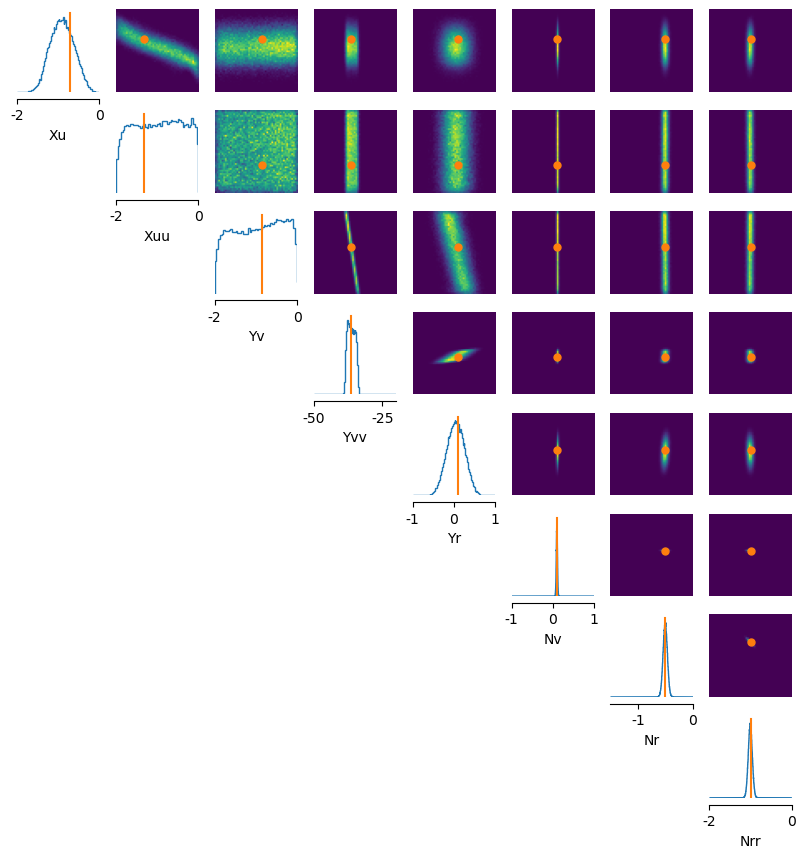

In [167]:
fig, ax = analysis.pairplot(
    samples,
    points=true_params,
    labels=labels,
    limits=limits,
)

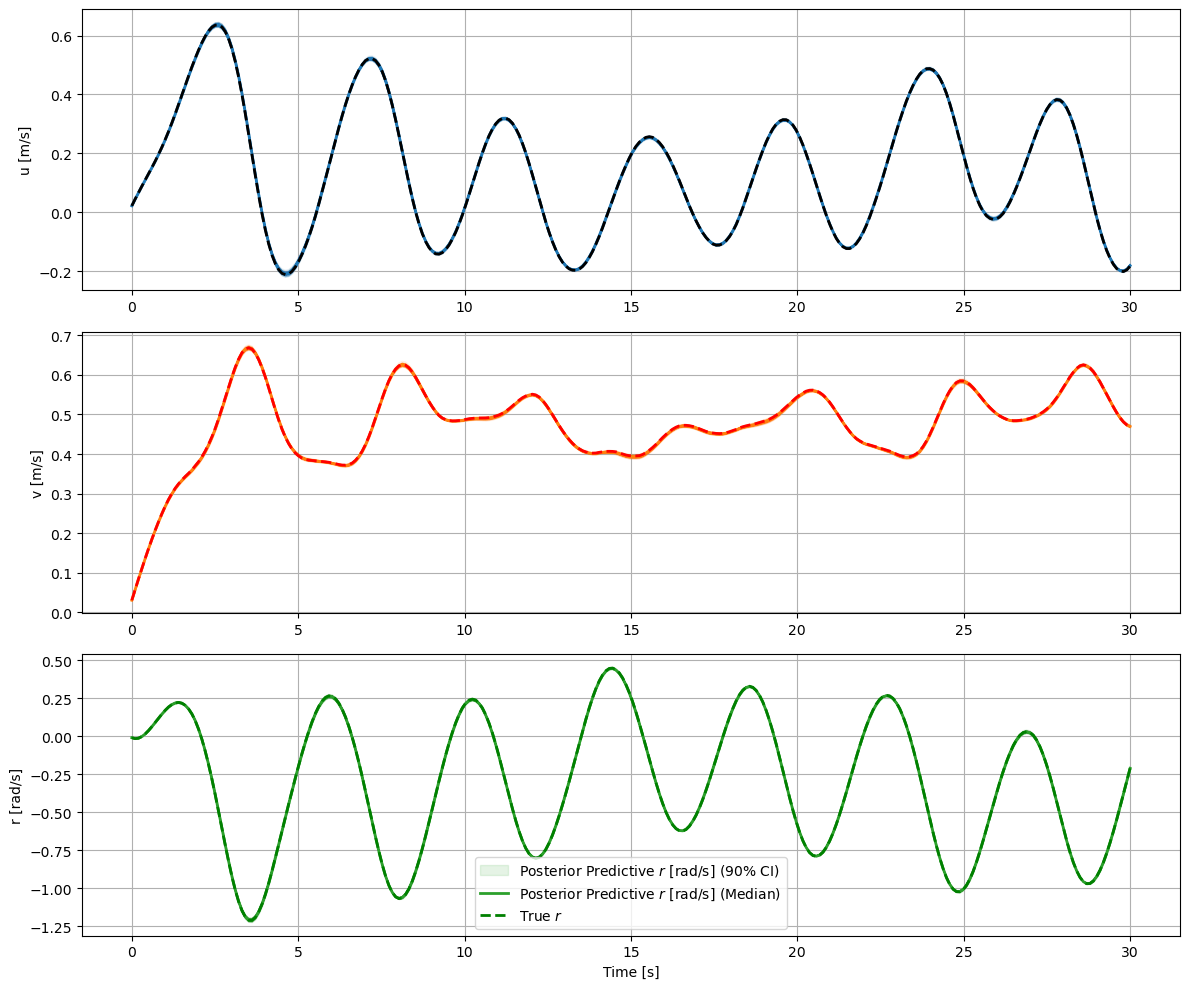

In [168]:
# true_hybrid = simulator_hybrid(true_params, seed=seed)

# plot_posterior_prediction_band_hybrid(
#     posterior,
#     x_o=x_summary_obs_hybrid,
#     simulator_hybrid=simulator_hybrid,
#     true_hybrid=true_hybrid,
#     num_samples=200,
#     show_samples=False,
#     seed=seed
# )

plot_posterior_prediction_band_amv(
    posterior,
    x_summary_obs_hybrid,
    simulator_raw=amv,
    num_samples=200,
    show_samples=True,
    seed=seed
)

In [22]:
# hidden_sizes = [64, 128]
# output_sizes = [16, 32]
# num_layers_list = [1, 2]

# learning_rates = [1e-4, 5e-4, 1e-3]
# batch_sizes = [64, 128, 256]

# training_configs = [
#     {"batch_size": 64, "lr": 1e-3},
#     {"batch_size": 128, "lr": 5e-4},
#     {"batch_size": 256, "lr": 1e-4},
# ]

# num_simulations_list = [1000, 10000]

hidden_sizes = [64]
output_sizes = [16]
num_layers_list = [1]

learning_rates = [1e-4, 5e-4, 1e-3]
batch_sizes = [64, 128, 256]

# training_configs = [
#     {"batch_size": 64, "lr": 1e-3},
#     {"batch_size": 128, "lr": 5e-4},
#     {"batch_size": 256, "lr": 1e-4},
# ]

num_simulations_list = [10000]

In [21]:
# Before grid search:
simulator_wrapper = process_simulator(simulator_hybrid, prior, prior_returns_numpy)
precomputed_data = {}
for num_sim in num_simulations_list:
    print(f"Generating training data for num_simulations={num_sim}")
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_sim)
    precomputed_data[num_sim] = (theta, x)

Generating training data for num_simulations=10000


  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]
labels=['Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr']

In [24]:
trajectory = amv(true_params.numpy(), noise_std=noise_std)
trajectory_smooth = torch.tensor(np.stack([
    savgol_filter(trajectory[:, i], window_length=15, polyorder=3)
    for i in range(trajectory.shape[1])
], axis=1), dtype=torch.float32)

sequence = trajectory_smooth.T
summary = extract_summary_stats(trajectory_smooth)
summary_norm = (summary - summary_mean) / (summary_std + 1e-8)

x_summary_obs_norm = torch.cat([sequence.flatten(), summary_norm])

In [25]:
def hybrid_pipeline(hidden_size, output_size, num_layers, learning_rate, batch_size, num_simulations):
        # Create LSTM and hybrid embedding
        lstm = LSTMEmbedding(
            input_size=3,
            hidden_size=hidden_size,
            output_size=output_size,
            num_layers=num_layers
        )
        embedding_net = HybridEmbedding(
            seq_embed_net=lstm,
            stats_dim=39,
            seq_channels=3,
            seq_len=steps,
            fused_dim=output_size
        )

        # Set up SBI
        density_estimator = posterior_nn(model="maf", embedding_net=embedding_net)
        inference = NPE(prior=prior, density_estimator=density_estimator)

        # Sample training data
        theta, x = precomputed_data[num_simulations]

        # Train posterior
        _ = inference.append_simulations(theta, x).train(learning_rate=learning_rate, training_batch_size=batch_size)
        posterior = inference.build_posterior()

        return posterior


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.0001, batch_size=64
 Neural network successfully converged after 273 epochs.
✅ MSE = 0.04840


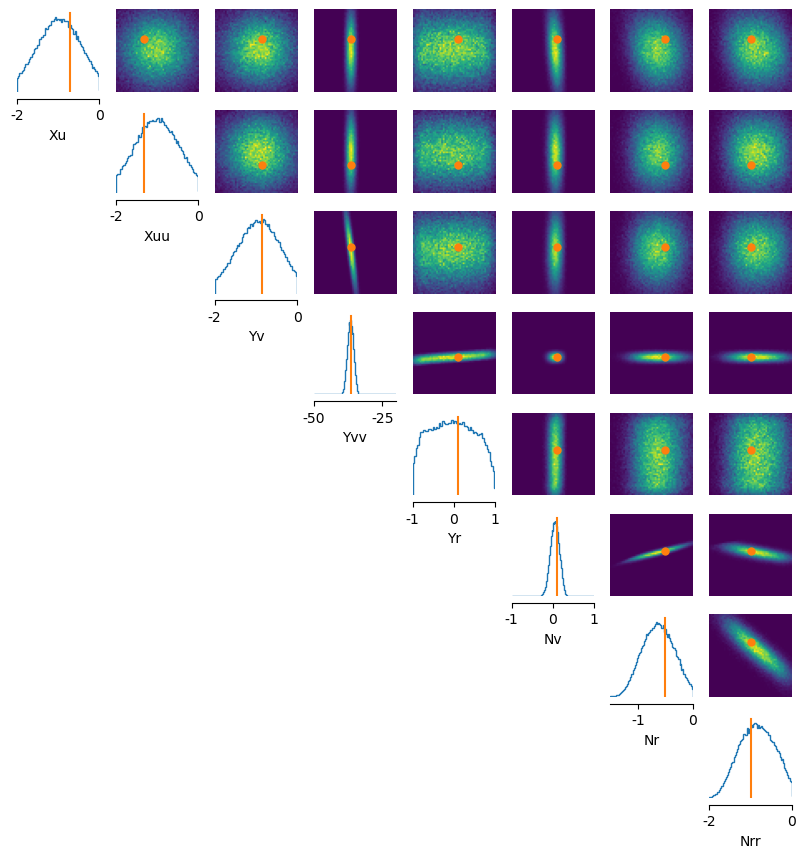

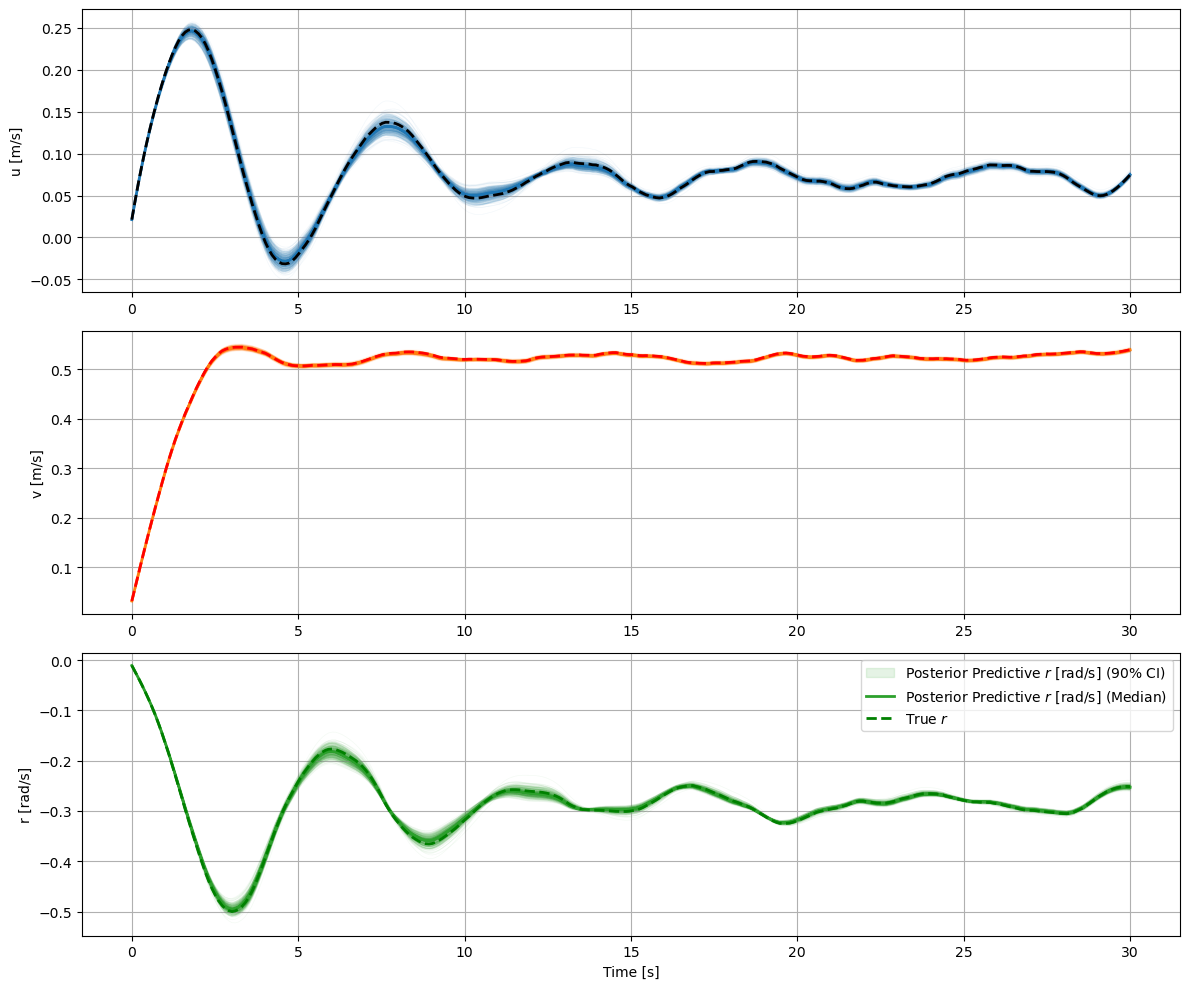


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.0001, batch_size=128
 Neural network successfully converged after 414 epochs.
✅ MSE = 0.04612


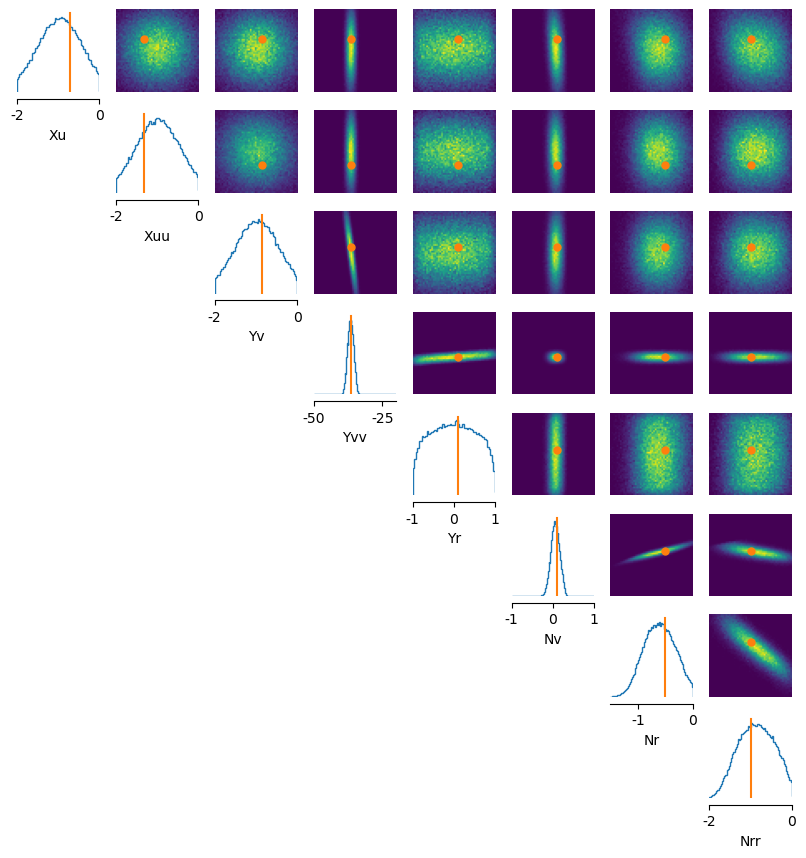

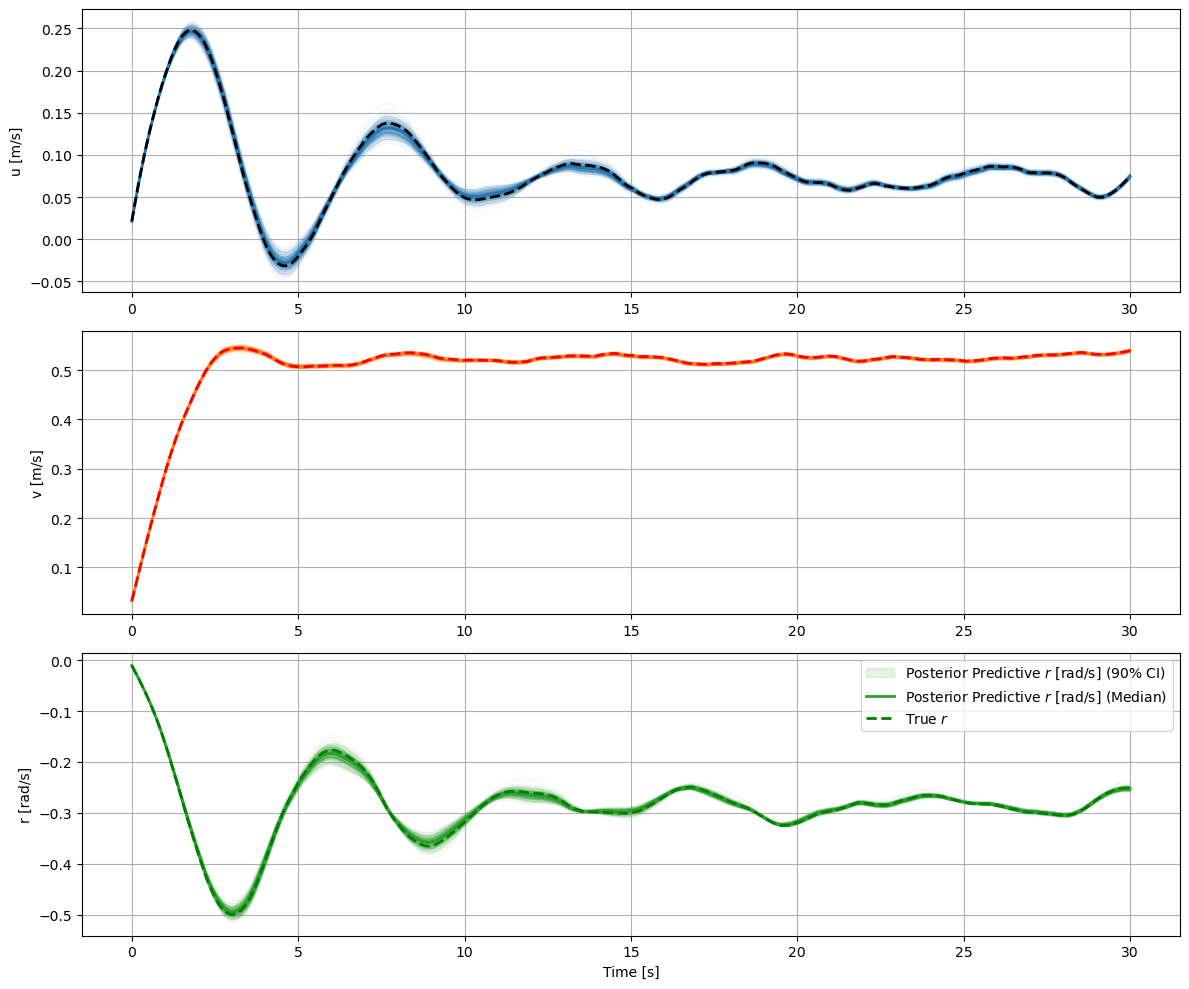


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.0001, batch_size=256
 Neural network successfully converged after 441 epochs.
✅ MSE = 0.05029


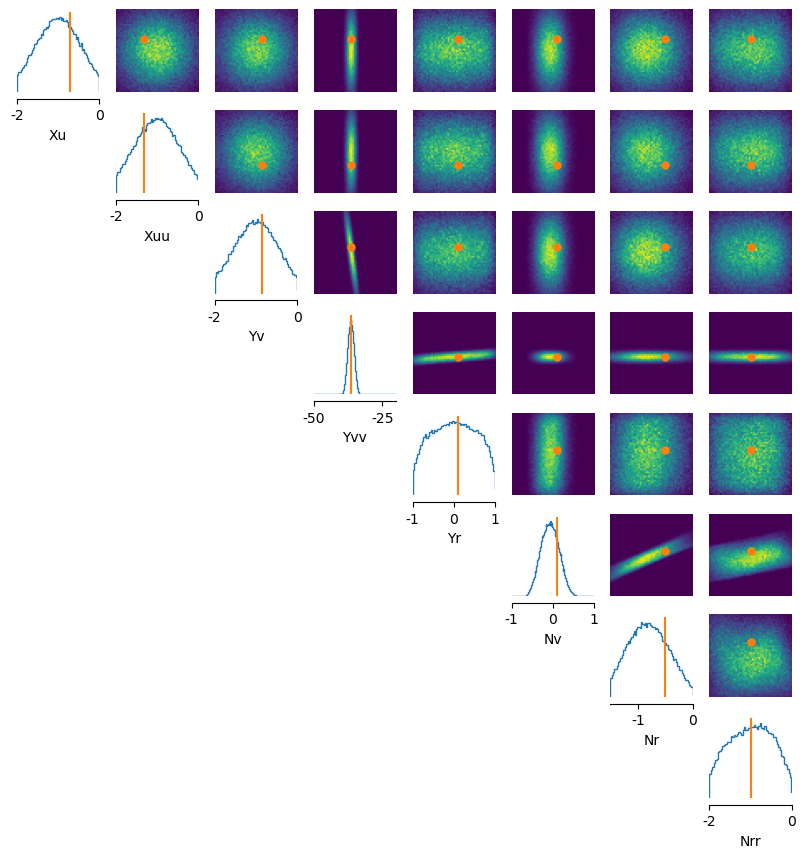

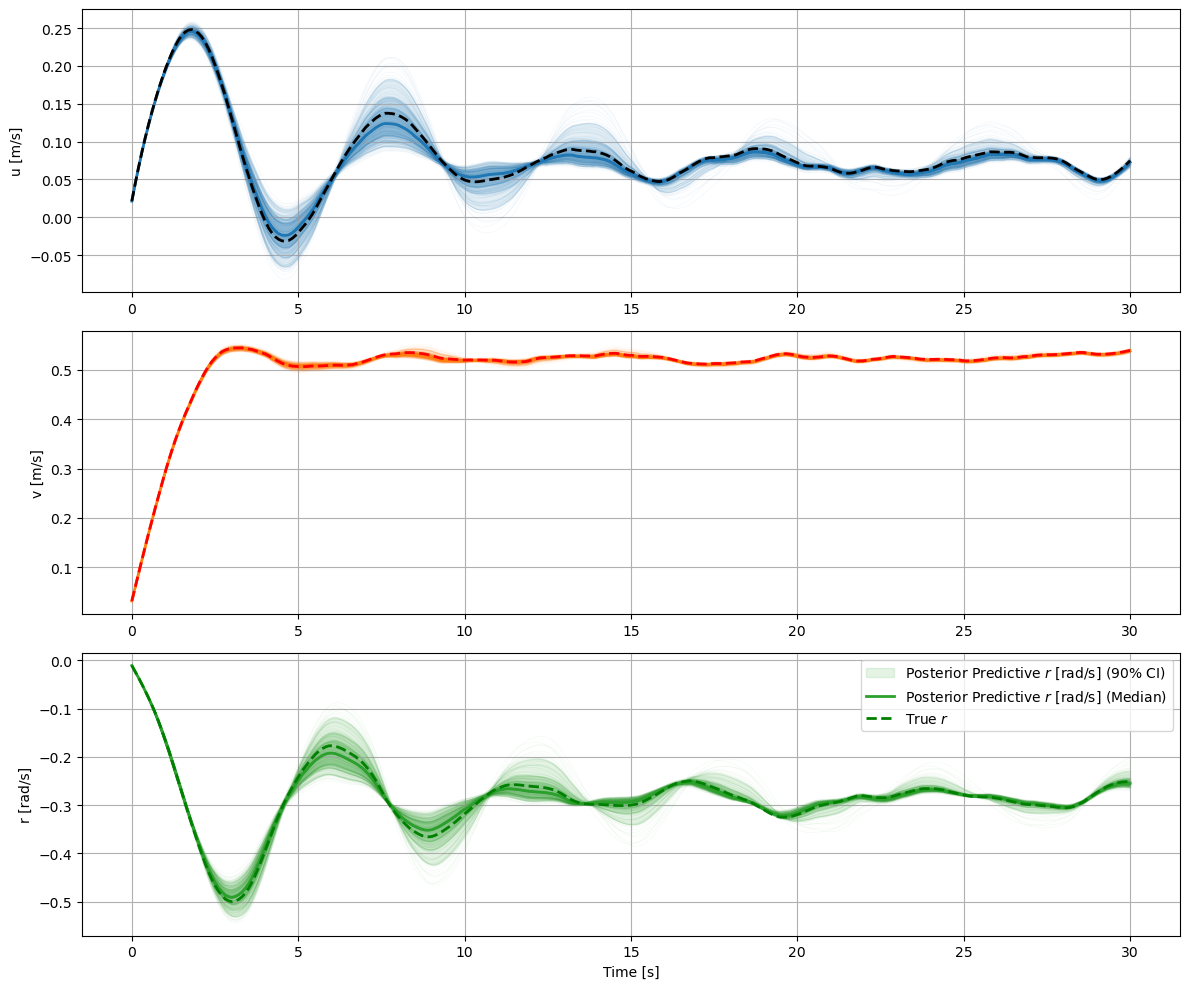


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.0005, batch_size=64
 Neural network successfully converged after 136 epochs.
✅ MSE = 0.03251


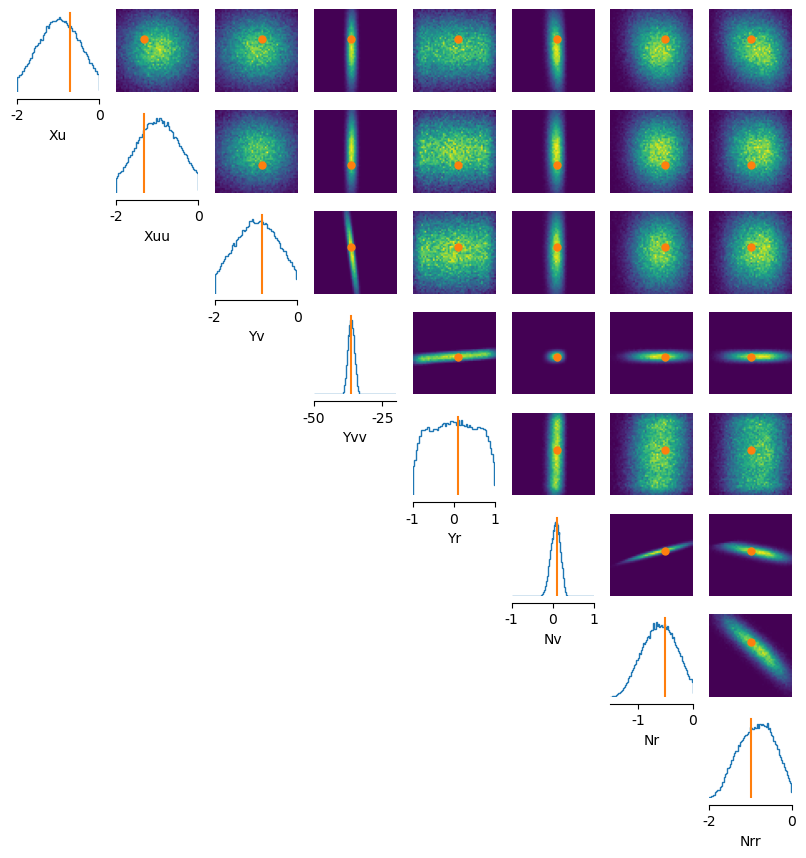

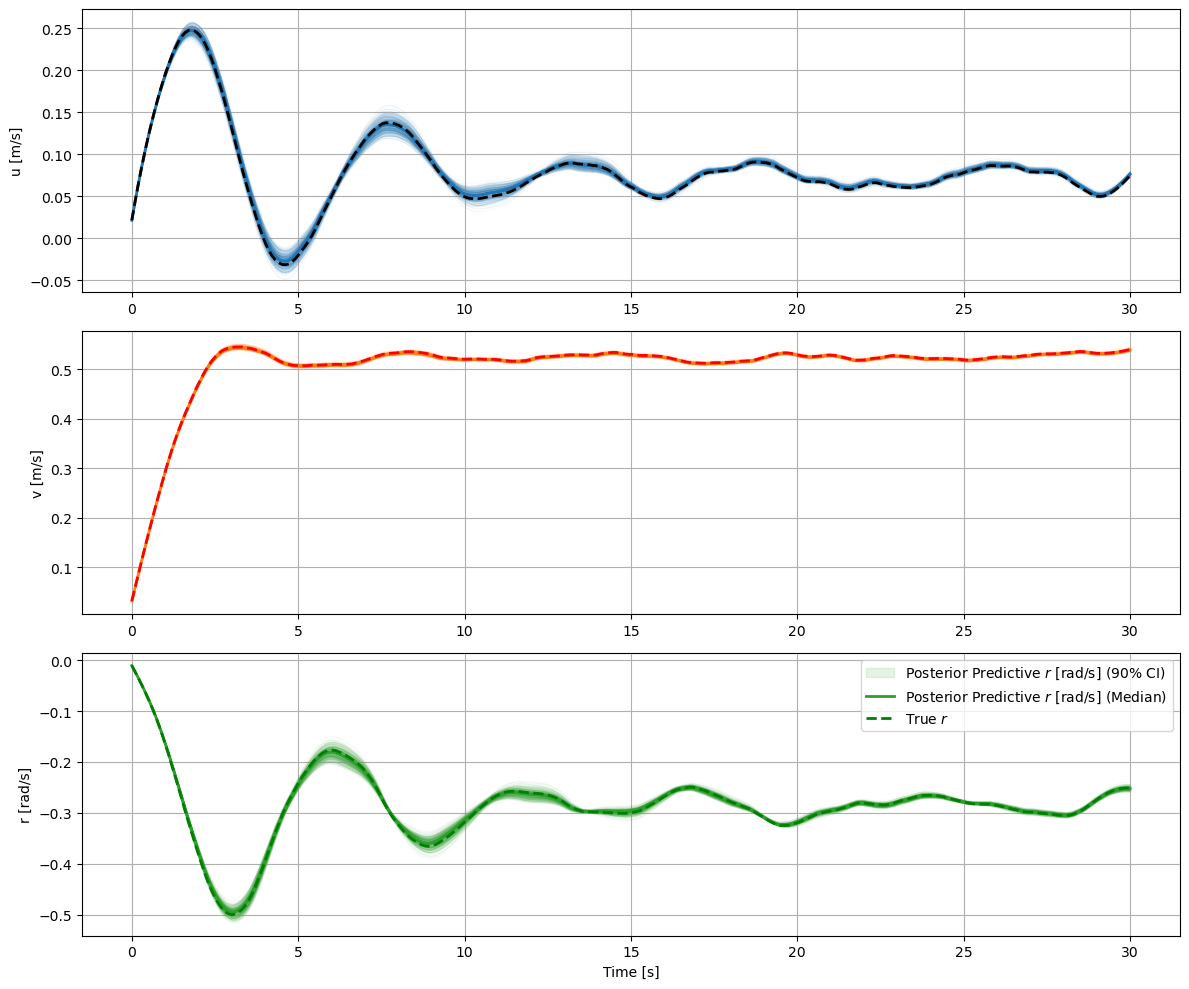


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.0005, batch_size=128
 Neural network successfully converged after 306 epochs.
✅ MSE = 0.04392


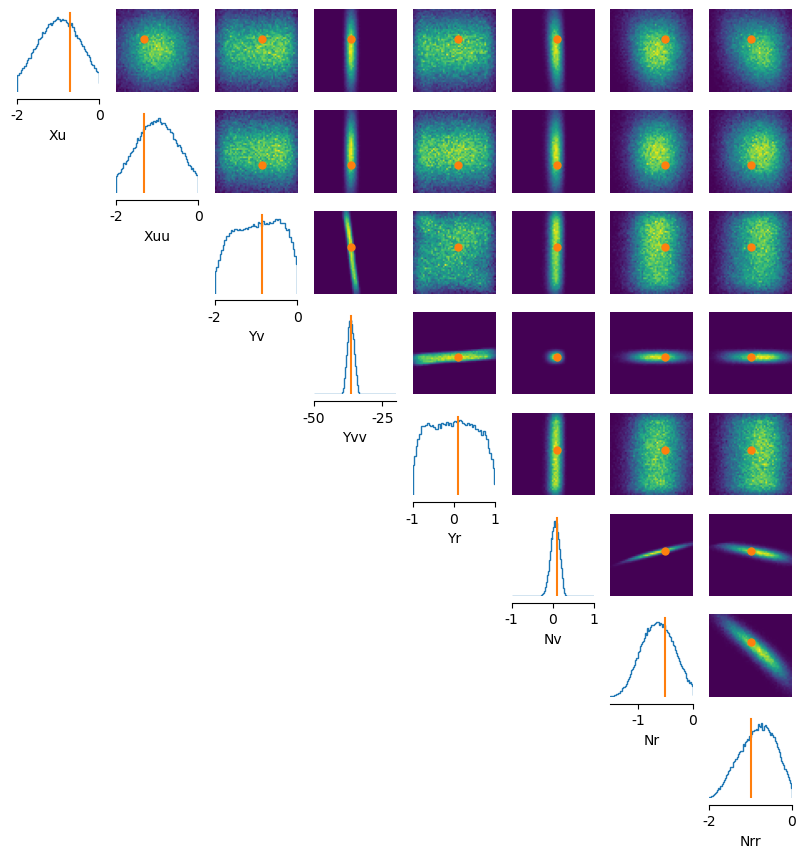

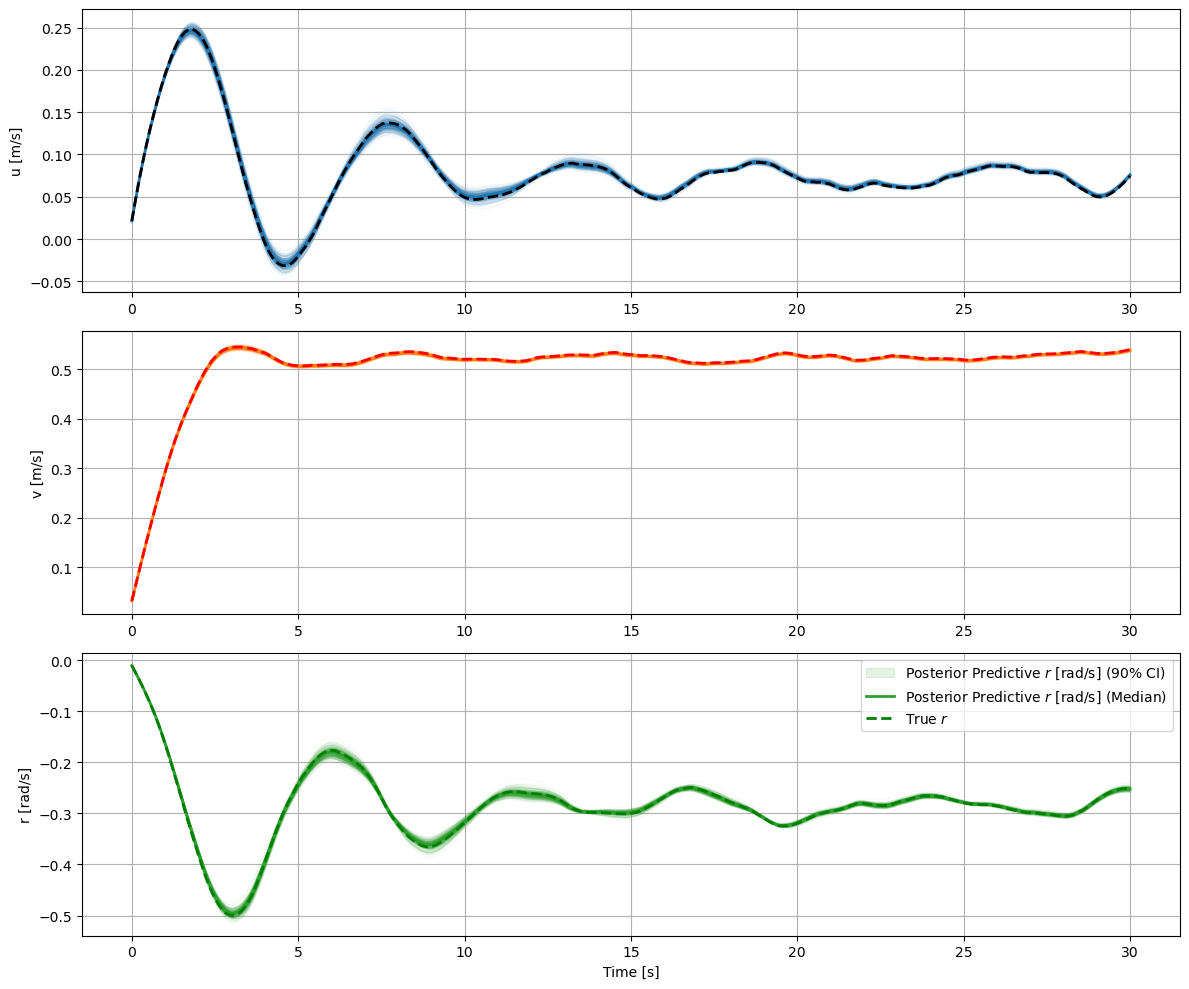


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.0005, batch_size=256
 Neural network successfully converged after 248 epochs.
✅ MSE = 0.03963


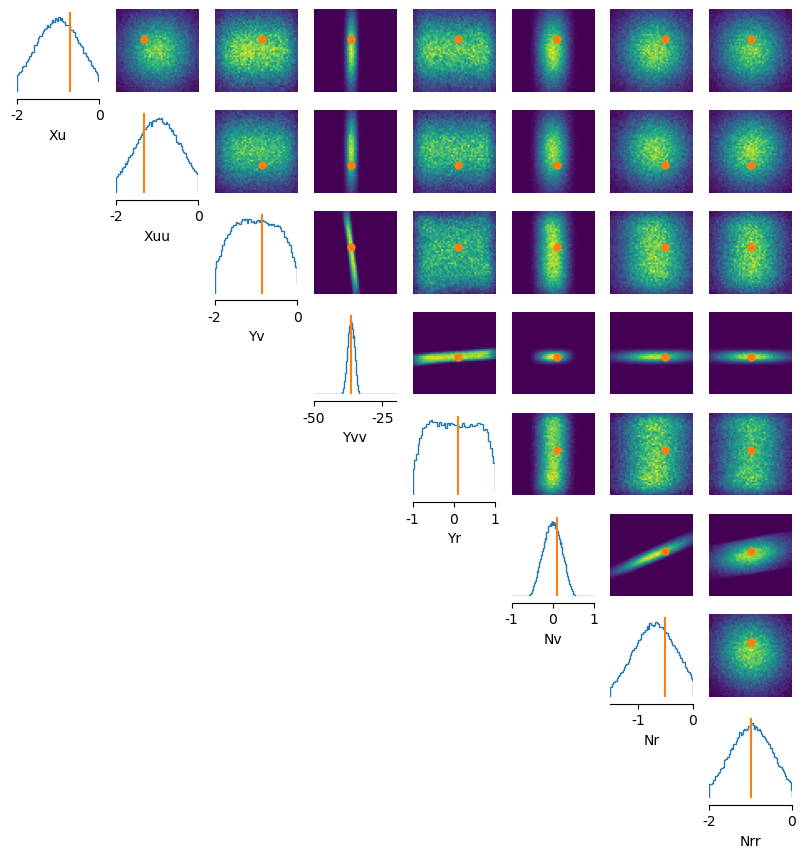

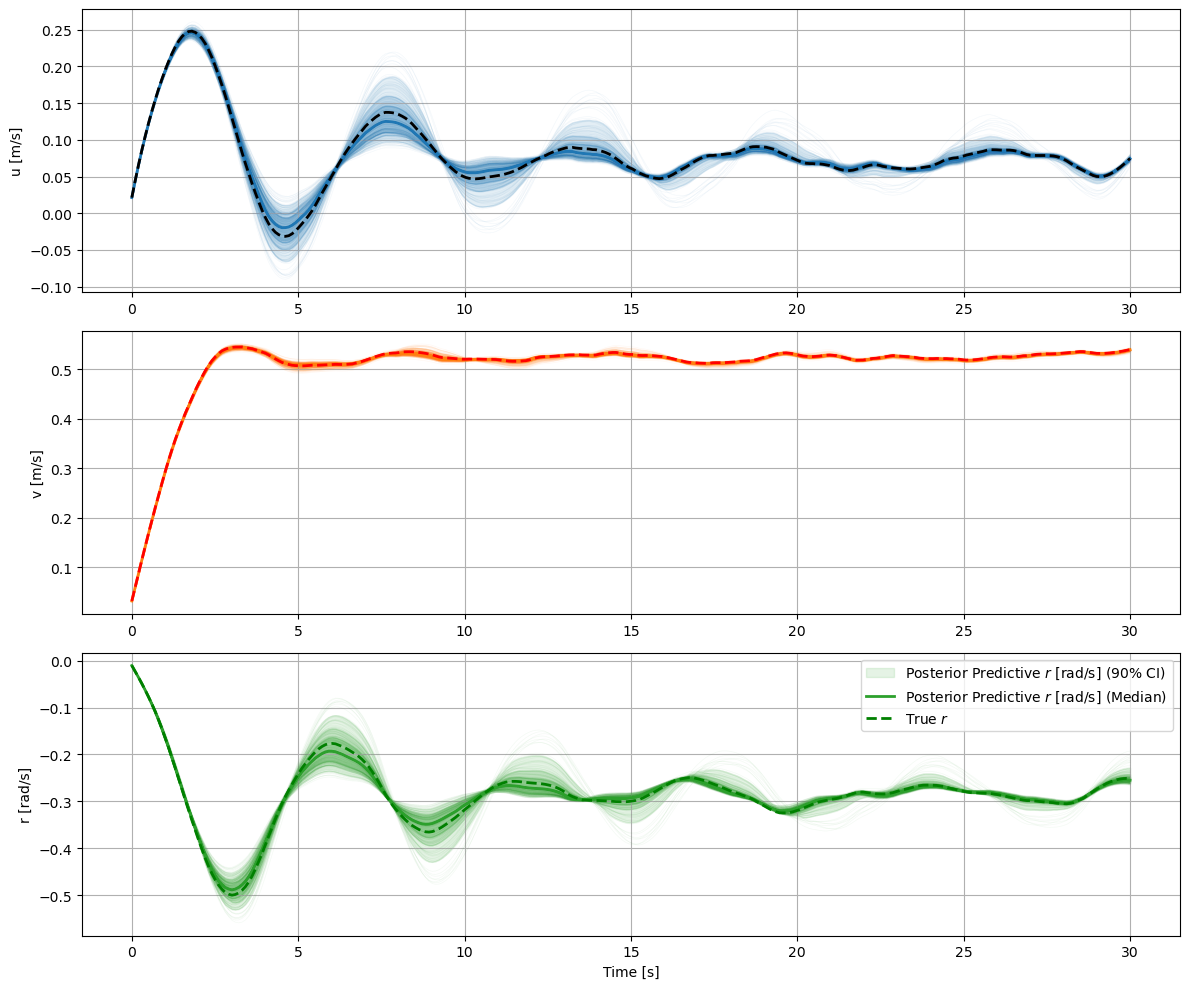


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.001, batch_size=64
 Neural network successfully converged after 136 epochs.
✅ MSE = 0.03720


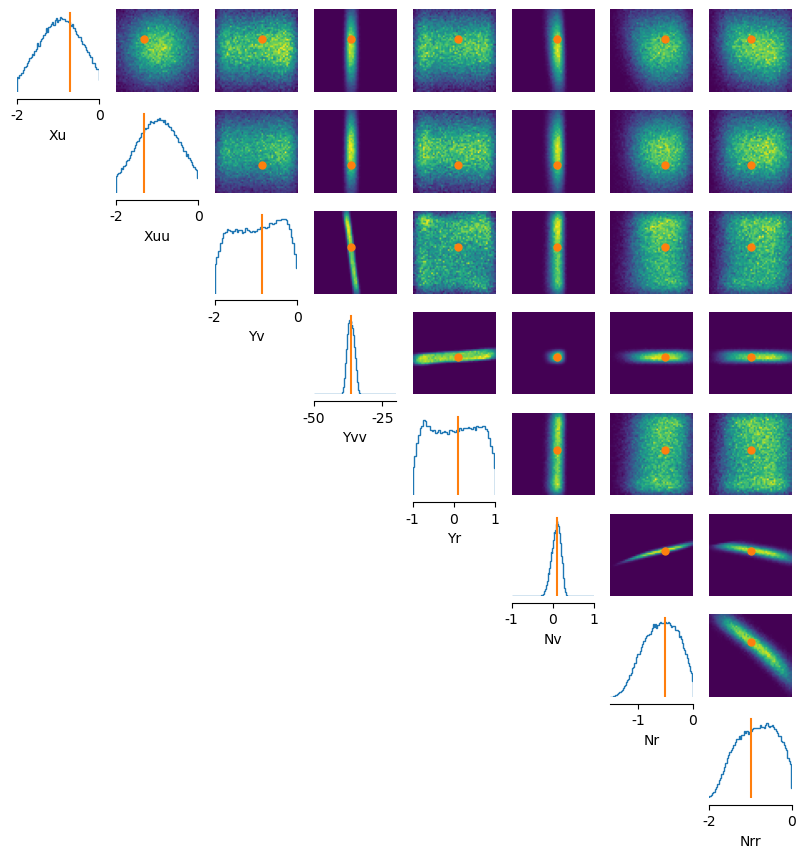

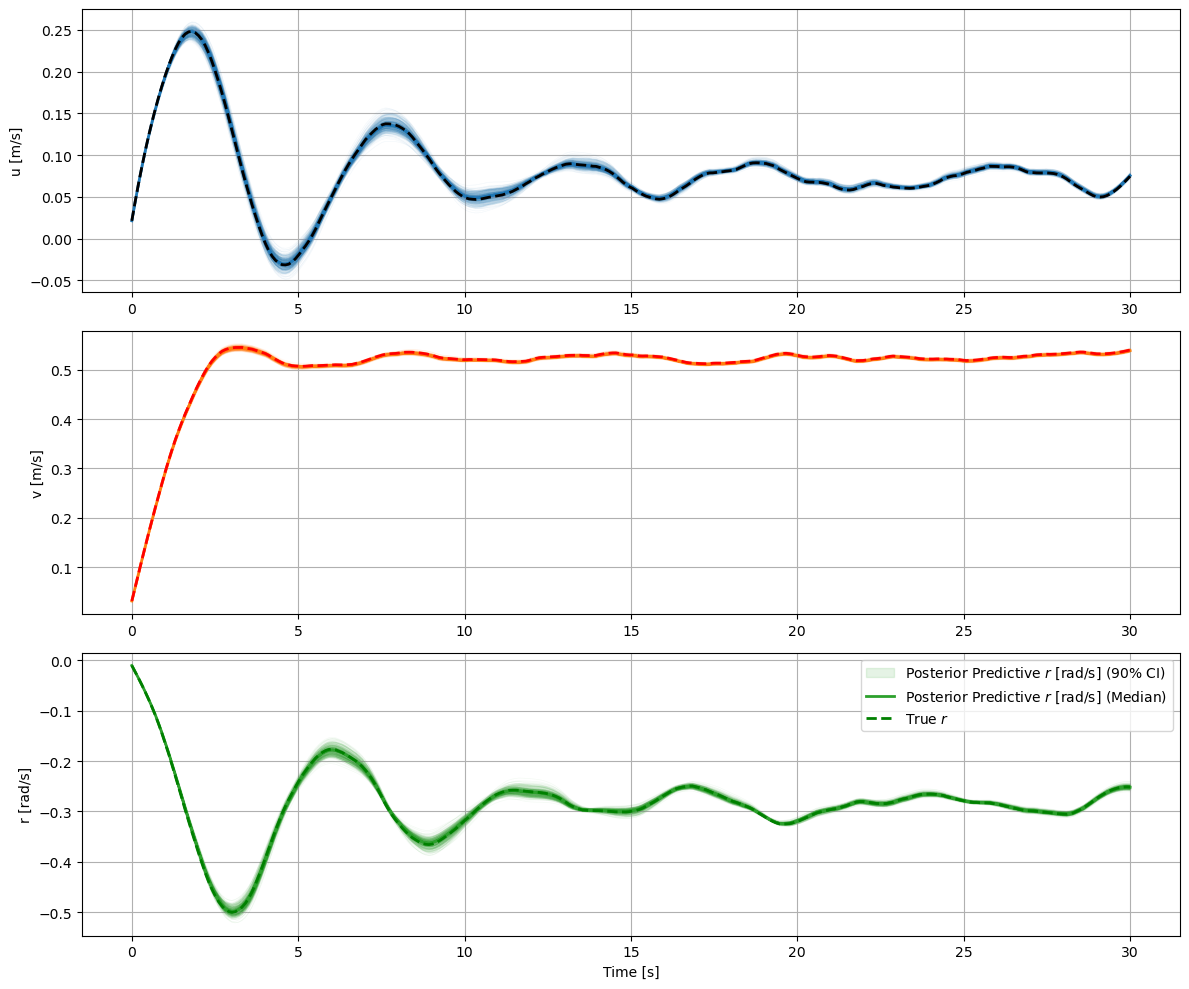


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.001, batch_size=128
 Neural network successfully converged after 218 epochs.
✅ MSE = 0.04358


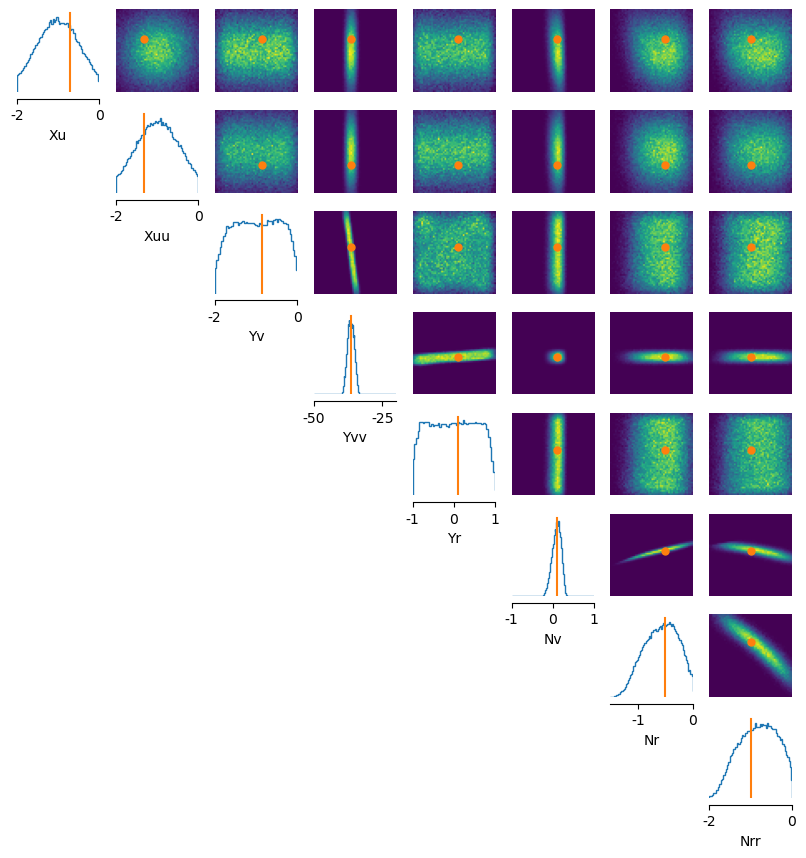

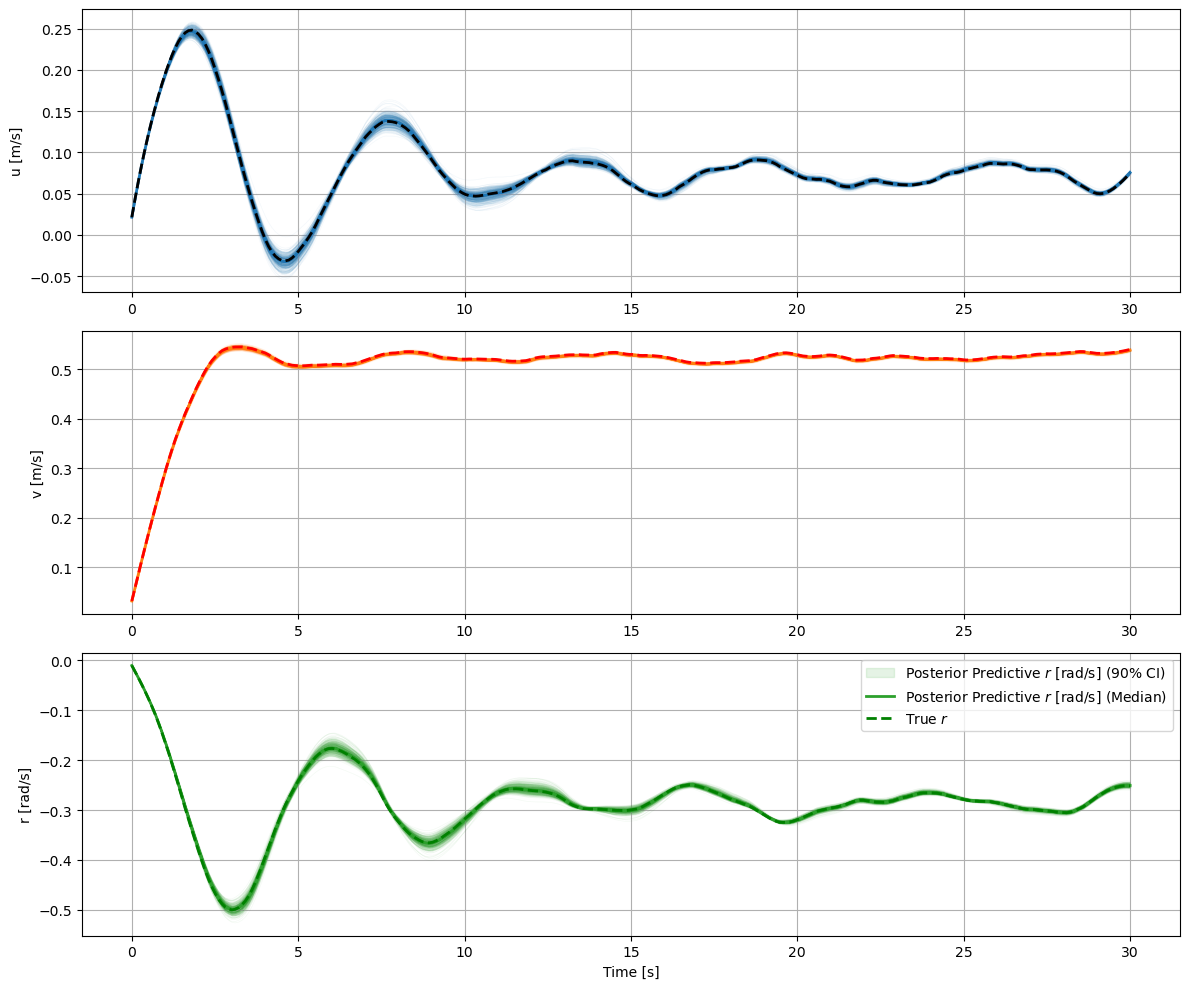


🔧 Trying num_simulations=10000 hidden=64, output=16, layers=1, learning_rate=0.001, batch_size=256
 Neural network successfully converged after 151 epochs.
✅ MSE = 0.05981


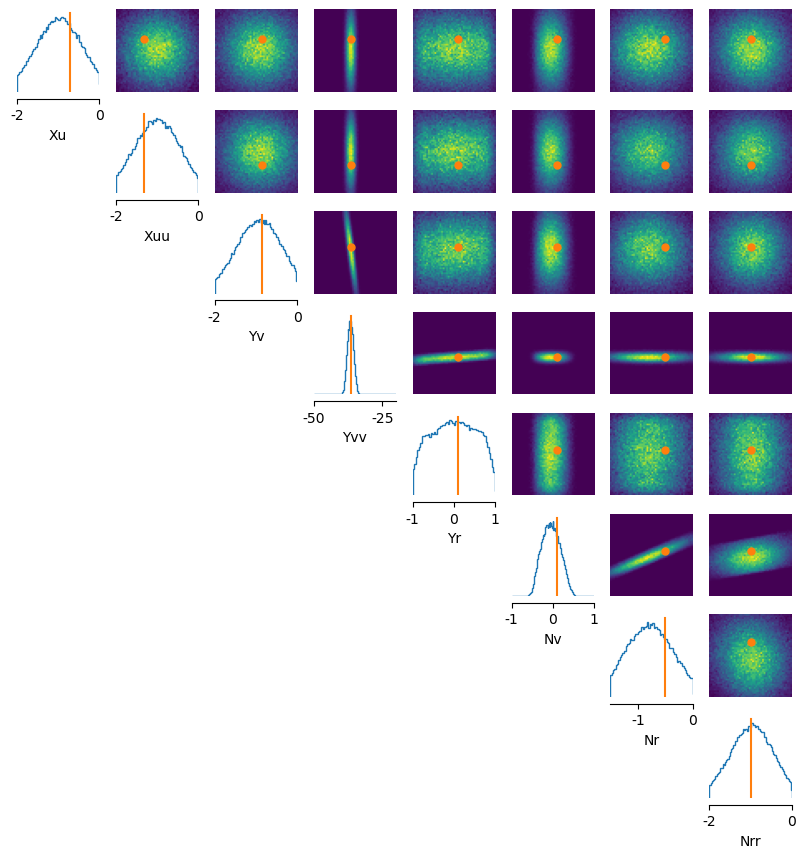

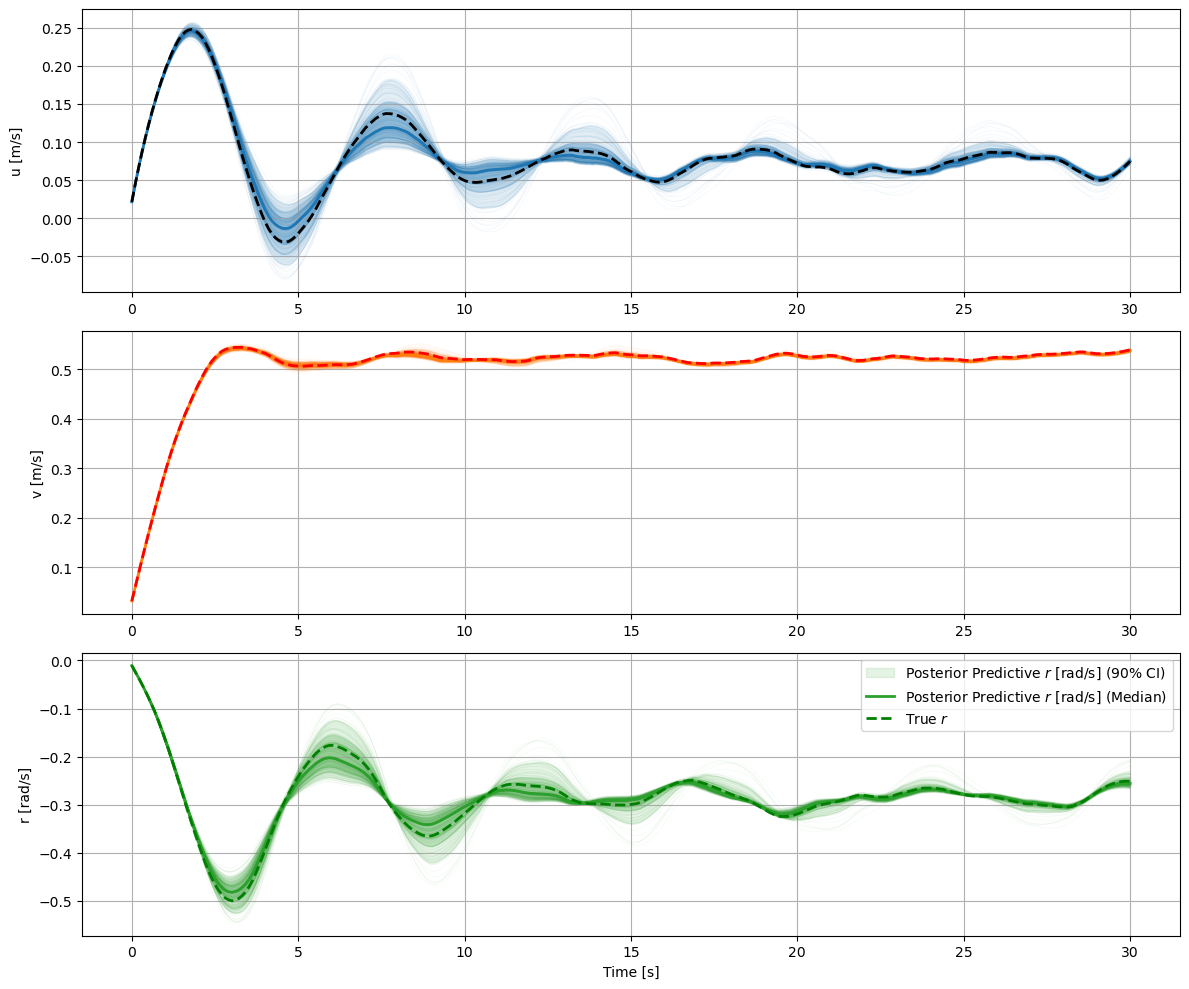

In [ ]:
# results = []

# for num_simulations in num_simulations_list:
#     for hidden_size in hidden_sizes:
#         for output_size in output_sizes:
#             for num_layers in num_layers_list:
#                 for learning_rate in learning_rates:
#                     for batch_size in batch_sizes:

#                         torch.manual_seed(seed)
#                         np.random.seed(seed)

#                         print(f"\n🔧 Trying num_simulations={num_simulations} hidden={hidden_size}, output={output_size}, layers={num_layers}, learning_rate={learning_rate}, batch_size={batch_size}")

#                         posterior = hybrid_pipeline(hidden_size, output_size, num_layers, learning_rate, batch_size, num_simulations)

#                         # Evaluate
#                         samples = posterior.sample((100000,), x=x_summary_obs_norm, show_progress_bars=False)
#                         inferred_mean = samples.mean(0)
#                         inferred_std = samples.std(dim=0) 
#                         mse = ((inferred_mean - true_params) ** 2).mean().item()
#                         squared_errors = (inferred_mean - true_params) ** 2

#                         lower = samples.quantile(0.05, dim=0)
#                         upper = samples.quantile(0.95, dim=0)

#                         coverage = ((true_params >= lower) & (true_params <= upper)).float().mean().item() 

#                         print(f"\n✅ MSE = {mse:.5f}")

#                         metadata = {
#                             "posterior": posterior,
#                             "config": {
#                                 "hidden_size": hidden_size,
#                                 "output_size": output_size,
#                                 "num_layers": num_layers,
#                                 "learning_rate": learning_rate,
#                                 "batch_size": batch_size,
#                                 "num_simulations": num_simulations,
#                                 "seed": seed,
#                             },
#                             "mse": mse,
#                             "squared_errors": squared_errors.tolist(),
#                             "posterior_mean": inferred_mean.tolist(),
#                             "posterior_std": inferred_std.tolist(),
#                             "posterior_coverage_90": coverage,
#                             "squared_errors": squared_errors.tolist()
#                         }

#                         with open(f"./models/amv_hybrid_num_sims-{num_simulations}_lr-{learning_rate}_batch_size-{batch_size}_hidden_size-{hidden_size}_output_size-{output_size}-num_layers_{num_layers}.pkl", "wb") as f:
#                             pickle.dump(metadata, f)

#                         fig, ax = analysis.pairplot(
#                             samples,
#                             points=true_params,
#                             labels=labels,
#                             limits=limits,
#                         )

#                         plot_posterior_prediction_band_amv(
#                             posterior,
#                             x_summary_obs_hybrid,
#                             simulator_raw=amv,
#                             num_samples=200,
#                             show_samples=True,
#                             seed=seed
#                         )

#                         results.append({
#                             "hidden_size": hidden_size,
#                             "output_size": output_size,
#                             "num_layers": num_layers,
#                             "learning_rate": learning_rate,
#                             "batch_size": batch_size,
#                             "num_simulations": num_simulations,
#                             "mse": mse,
#                             "posterior_mean": inferred_mean.tolist(),
#                             "posterior_std": inferred_std.tolist(),
#                             "squared_errors": squared_errors.tolist()
#                         })

In [30]:
with open("amv_results_partial_2.pkl", "wb") as f:
    pickle.dump(results, f)

In [31]:
import pandas as pd

df = pd.DataFrame(results)
df.to_csv("amv_results_partial_2.csv", index=False)

In [ ]:
df.to_json("amv_results_partial_2.json", index=False)